# **Movie Review Sentiment Analysis**


**Sentiment Analysis**

Constructed a world-level LSTM model for identifying positive and negative reviews.

In [ ]:
# load standard modules/libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# load special modules/libraries
import os
import warnings
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from collections import Counter
import string
import re
from tqdm  import tqdm

# load pytorch modules/libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset,DataLoader


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Part 1



### Part (i)

In this part I examine some examples of positive and negative reviews.

Below I will share some observations on the quality of the data and any challenges I foresee in working with these data.

In [ ]:
# download IMDB review data
from google.colab import files
IMDB_data = files.upload()

Saving IMDB Dataset.csv to IMDB Dataset.csv


In [ ]:
# load dataset
df = pd.read_csv("IMDB Dataset.csv")

# process into data and labels
X = df['review'].values
y = df['sentiment'].values

In [ ]:
print(X)

["One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the f

In [ ]:
print(y)

['positive' 'positive' 'positive' ... 'negative' 'negative' 'negative']


In [ ]:
pd.set_option('display.max_colwidth', None)
df.head(10)

,review,sentiment
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fact that it goes where other shows wouldn't dare. Forget pretty pictures painted for mainstream audiences, forget charm, forget romance...OZ doesn't mess around. The first episode I ever saw struck me as so nasty it was surreal, I couldn't say I was ready for it, but as I watched more, I developed a taste for Oz, and got accustomed to the high levels of graphic violence. Not just violence, but injustice (crooked guards who'll be sold out for a nickel, inmates who'll kill on order and get away with it, well mannered, middle class inmates being turned into prison bitches due to their lack of street skills or prison experience) Watching Oz, you may become comfortable with what is uncomfortable viewing....thats if you can get in touch with your darker side.",positive
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only ""has got all the polari"" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell's murals decorating every surface) are terribly well done.",positive
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I'd laughed at one of Woody's comedies in years (dare I say a decade?). While I've never been impressed with Scarlet Johanson, in this she managed to tone down her ""sexy"" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than ""Devil Wears Prada"" and more interesting than ""Superman"" a great comedy to go see with friends.",positive
3,"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zom

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49257 entries, 0 to 49256
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     49257 non-null  object
 1   sentiment  49257 non-null  object
dtypes: object(2)
memory usage: 769.8+ KB


In [ ]:
print("Positive Reviews:\n")
print(df[df['sentiment'] == 'positive']['review'].head())

# Display a few negative reviews
print("\nNegative Reviews:\n")
print(df[df['sentiment'] == 'negative']['review'].head())

Positive Reviews:

0    One of the other reviewers has mentioned that ...
1    A wonderful little production. <br /><br />The...
2    I thought this was a wonderful way to spend ti...
4    Petter Mattei's "Love in the Time of Money" is...
5    Probably my all-time favorite movie, a story o...
Name: review, dtype: object

Negative Reviews:

3     Basically there's a family where a little boy ...
7     This show was an amazing, fresh & innovative i...
8     Encouraged by the positive comments about this...
10    Phil the Alien is one of those quirky films wh...
11    I saw this movie when I was about 12 when it c...
Name: review, dtype: object



The dataset has clear binary labels ('positive' and 'negative'), which is ideal for a binary classification task like sentiment analysis. The reviews provided seem to have a good mix of opinions and styles, which is beneficial for training a model to understand different expressions of sentiments. The reviews contain HTML tags ``` e.g., <br /><br /> ```. These don't provide any meaningful information about the sentiment of the review and will need to be cleaned out of the text. The dataset includes a variety of language uses, from formal to informal and different sentence structures, which is good for training a robust model.

Understanding context may be difficult in reviews that contain sarcasm or nuances in the language that is used. For instance, reviewer 9 says:

> "If you like original **gut wrenching** laughter you will like this movie. If you are young or old then you will love this movie, hell even my mom liked it. Great Camp!!!"

Gut-wrenching is a word usually used to describe something negative however, the sentiment of this review is positive. Another example is:

> "This show was an **amazing**, **fresh** & **innovative** idea in the 70's when it first aired. The first 7 or 8 years were **brilliant**, but things dropped off after that. By 1990, the show was not really funny anymore, and it's continued its decline further to the complete waste of time it is today. It's truly disgraceful how far this show has fallen. The writing is painfully bad, the performances are almost as bad - if not for the mildly **entertaining** respite of the guest-hosts, this show probably wouldn't still be on the air. I find it so hard to believe that the same creator that hand-selected the original cast also chose the band of hacks that followed. How can one recognize such **brilliance** and then see fit to replace it with such mediocrity? I felt I must give 2 stars out of respect for the original cast that made this show such a **huge success**. As it is now, the show is just awful. I can't believe it's still on the air."

This review is very clearly negative but the reviewer employs a number of "positive" words (bolded) and yet the sentiment is negative.

Looking at these positive and negative reviwes we also see the huge variance in review length. Deciding on an appropriate sequence length for padding the reviews can be challenging. Too long, and we may introduce too much padding, making the training inefficient; too short, and we could lose important information.



### Part (ii)

Next I will perform summary statistics on the dataset.

To view the distribution of how many positive reviews and negative reviews are there, I will generate a histogram to compare the average character length for positive and negative reviews.

In [ ]:
df['review_length'] = df['review'].apply(len) # New column with the len of each entry
average_length = df['review_length'].mean()
max_length = df['review_length'].max()
min_length = df['review_length'].min()

print(f"Average Review Length: {average_length} characters")
print(f"Longest Review Length: {max_length} characters")
print(f"Shortest Review Length: {min_length} characters")

Average Review Length: 1309.43102 characters
Longest Review Length: 13704 characters
Shortest Review Length: 32 characters


In [ ]:
sentiment_counts = df['sentiment'].value_counts()
print("Number of reviews by sentiment:")
sentiment_counts

Number of reviews by sentiment:


positive    25000
negative    25000
Name: sentiment, dtype: int64

In [ ]:
grouped = df.groupby('sentiment')['review_length']

average_lengths = grouped.mean()
print("Average Review Lengths:")
print(average_lengths)

median_lengths = grouped.median()
print("\nMedian Review Lengths:")
print(median_lengths)

Average Review Lengths:
sentiment
negative    1294.06436
positive    1324.79768
Name: review_length, dtype: float64

Median Review Lengths:
sentiment
negative    973.0
positive    968.0
Name: review_length, dtype: float64


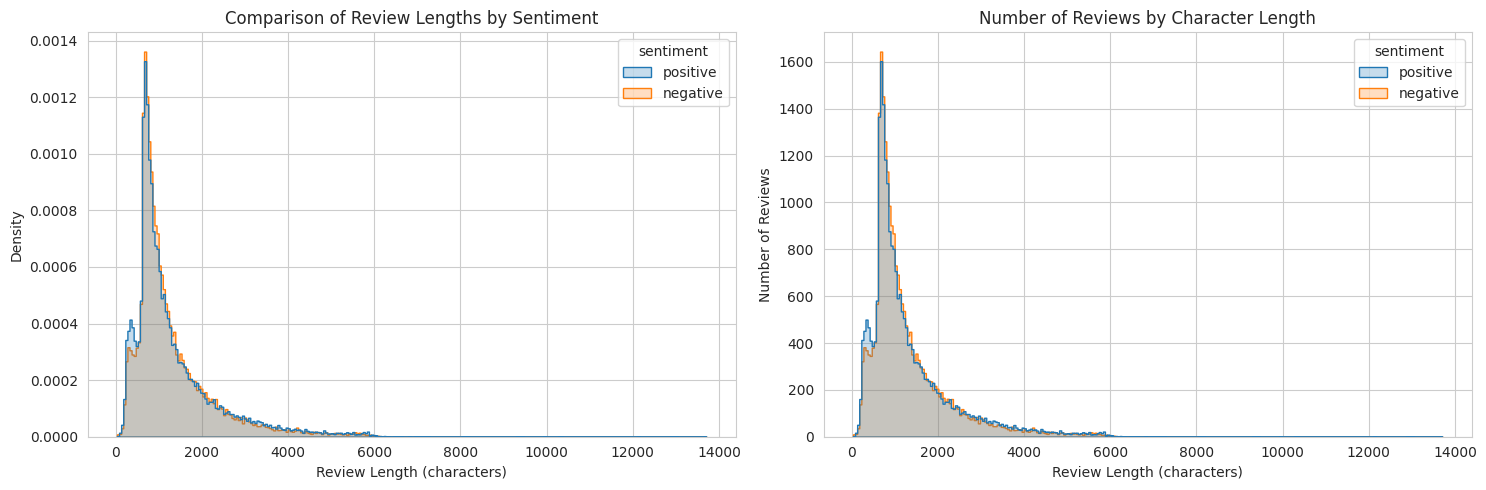

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create a figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Create the first histogram (Density)
sns.histplot(data=df, x='review_length', hue='sentiment', element='step', stat='density', common_norm=False, ax=axes[0])
axes[0].set_title('Comparison of Review Lengths by Sentiment')
axes[0].set_xlabel('Review Length (characters)')
axes[0].set_ylabel('Density')

# Create the second histogram (Count)
sns.histplot(data=df, x='review_length', hue='sentiment', element='step', kde=False, ax=axes[1])
axes[1].set_title('Number of Reviews by Character Length')
axes[1].set_xlabel('Review Length (characters)')
axes[1].set_ylabel('Number of Reviews')

# Display the plots
plt.tight_layout()
plt.show()

In [ ]:
'''
Past a character length of 6000, there seems to be a few outliers in the histogram
that have an avg review length of over 6000. Below we are checking to see how many
reviews are greater than 6000 and if these longer reviews lean toward a particular
sentiment.
'''

for num in range(6900, 13750, 1000):
    ch_len = num
    long_reviews = df[df['review_length'] > ch_len]
    count_long_reviews = long_reviews.shape[0]

    print(f"\nNumber of reviews longer than {ch_len} characters: {count_long_reviews}")

    if count_long_reviews > 0:
        sentiment_counts_long = long_reviews['sentiment'].value_counts()
        percent_distribution = sentiment_counts_long / count_long_reviews * 100
        print(f"Percent Distribution of Sentiment for Reviews Over {ch_len} Characters:")
        print(percent_distribution.to_string())
    else:
        print(f"No reviews longer than {ch_len} characters.")


Number of reviews longer than 6900 characters: 25
Percent Distribution of Sentiment for Reviews Over 6900 Characters:
positive    72.0
negative    28.0

Number of reviews longer than 7900 characters: 14
Percent Distribution of Sentiment for Reviews Over 7900 Characters:
positive    85.714286
negative    14.285714

Number of reviews longer than 8900 characters: 10
Percent Distribution of Sentiment for Reviews Over 8900 Characters:
positive    90.0
negative    10.0

Number of reviews longer than 9900 characters: 7
Percent Distribution of Sentiment for Reviews Over 9900 Characters:
positive    100.0

Number of reviews longer than 10900 characters: 4
Percent Distribution of Sentiment for Reviews Over 10900 Characters:
positive    100.0

Number of reviews longer than 11900 characters: 4
Percent Distribution of Sentiment for Reviews Over 11900 Characters:
positive    100.0

Number of reviews longer than 12900 characters: 3
Percent Distribution of Sentiment for Reviews Over 12900 Characters:


**General Observations**
* The dataset is balanced with an equal number of positive and negative reviews (25,000 each), which reduces the likelihood of bias toward a particular sentiment.
* The average and median lengths of positive and negative reviews are quite similar. This suggests that, on average, the amount of characters provided by reviewers is pretty mych consistent regardless of sentiment. The histogram illustraits the similarity in the distibution of the data as well.
* As the character length increases beyond 6000 characters, there's a clear trend showing a higher proportion of positive reviews. Reviews longer than 9000 characters are exclusively positive.

**Implications:**
* LSTM and traditional RNN models may struggle with very long sequences due to the vanishing gradient problem, although LSTM models are generally better at handling longer dependencies than vanilla RNNs. The presence of extremely long  could be a challenge in terms of both computational resources and model performance.
* The trend towards positive sentiment in longer reviews could lead the model to associate longer text with a positive sentiment, which might not always be accurate.
* As there is a wide range of review lengths, careful preprocessing and tokenization will be necessary.
* The similarity in average and median lengths for positive and negative reviews is advantageous because it suggests that the model won't be biased towards a particular sentiment based on length alone. However, the increasing skew towards positive reviews in longer texts could potentially bias the model - may need to address this issue by setting a  maximum length.
* Given the scarcity of very long negative reviews, consider data augmentation techniques for negative reviews to ensure the model learns to handle long negative texts effectively.


### Part (iii)

The following helper code will be used to process the data before we can train our LSTM model. Below I will comment on what processing steps are performed in the code provided below and why these steps are necessary or beneficial to training and LSTM.

In [ ]:
X[0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [ ]:
def preprocess_string(str1):
    # remove all non-word characters excluding number and letters
    str1= re.sub(r"[^\w\s]",'',str1)
    # remove all whitespace with no space
    str1= re.sub(r"\s",'',str1)
    # replace digits with no space
    str1= re.sub(r"\d",'',str1)
    return str1

def preprocess_sentence(sen1):
    word_list=[]
    stop_word = set(stopwords.words("english"))
    for word in sen1.lower().split():
        word = preprocess_string(word)
        if word not in stop_word and word!='':
            word_list.append(word)
    return word_list

def get_stoi(data):
    word_list=[]
    for review in data:
        word_list.extend(preprocess_sentence(review))
    corpus = Counter(word_list)
    print(corpus.get)
    # sorting on the basis of most common words
    corpus_ =sorted(corpus,key= corpus.get,reverse=True)[:1000] # originally 1000
    # creating a dict
    stoi =  {ch:i+1 for i,ch in enumerate(corpus_)}
    return stoi

def tokenize(data, labels, stoi):
    # tokenize
    data_encoded = []
    for review in data:
        data_encoded.append([stoi[word] for word in preprocess_sentence(review)
                                     if word in stoi.keys()])

    labels_encoded = [1 if label =='positive' else 0 for label in labels]

    return np.array(data_encoded), np.array(labels_encoded)

def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review)!=0:
            features[ii, -len(review):] = np.array(review)[:seq_len]

    return features



**preprocess_string** - removes non-word characters:
* Removes punctuation and special characters
  * Simplifies the text data, focusing on the content (words) rather than
 less relevant info such as formatting or punctuation.
* Removes all whitespace characters - this function is called on each word in the function preprocess_sentence - this means its removing the white space around each word, not all the white space in the review.
* Removes all digits - this focuses the model on textual content.

**preprocess_sentence** - Lowercases text and removes stopwords:
* Lowercasing standardizes the text data
* removing stopwords (i.e. "the", "is", etc.) helps reduce size of the feature space to focus on more meaningful words.

**get_stoi**- Word List Creation:
* Collects all the words across all reviews to create a corpus - i.e. a collection of word frequencies.
* Then selects the top 1000 most frequent words -  reduces the complexity of the model
* Then creates dictionary (stoi) where each unique word is assigned a unique integer - converts textual data to numerical input
  * mapping ensures that the same word is represented by the same number across different texts - this maintains consistency in data representation.

**tokenize** - Tokenization:
* If a word is not in the stoi dictionary, it ignores it.
 * Converts the sentiment labels ('positive' or 'negative') into binary labels (1 or 0) - machine learning models need numerical labels.

**padding_** -  Padding Sequences):
* Makes all input sequences the same length by padding shorter sequences with zeros.
* LSTM layers expect inputs of the same size, so padding sequences to a consistent length is essential for training.
.

### Part (iv)
Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split. Then apply the above processing steps to prepare your data for training.

Set the padding of the reviews to 500.

In [ ]:
df.drop('review_length', axis=1, inplace=True)
pd.reset_option('all')

In [ ]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
X_train, X_remaining, y_train, y_remaining = train_test_split(X, y, test_size=0.2, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_remaining, y_remaining, test_size=0.5, random_state=42)

In [ ]:
stoi = get_stoi(X_train)
X_train_encoded, y_train_encoded = tokenize(X_train, y_train, stoi)
X_valid_encoded, y_valid_encoded = tokenize(X_valid, y_valid, stoi)
X_test_encoded, y_test_encoded = tokenize(X_test, y_test, stoi)

seq_len = 500

# Apply padding
X_train_padded = padding_(X_train_encoded, seq_len)
X_valid_padded = padding_(X_valid_encoded, seq_len)
X_test_padded = padding_(X_test_encoded, seq_len)

<built-in method get of Counter object at 0x7a1b6d94e430>


<ipython-input-35-a42a381dd503>:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data_encoded), np.array(labels_encoded)


### Part (v)

Create a DataLoader that will allow you to load the training and validation data in mini-batches. Then generate a dataset of batch size of 16 to verify that the DataLoader works as intended.

In [ ]:
# TO BE COMPLETED
import torch
from torch.utils.data import TensorDataset, DataLoader

X_train_tensor = torch.tensor(X_train_padded, dtype=torch.long)
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.float32)
X_valid_tensor = torch.tensor(X_valid_padded, dtype=torch.long)
y_valid_tensor = torch.tensor(y_valid_encoded, dtype=torch.float32)

In [ ]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)

In [ ]:
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Verifying that DataLoader is working
for i, (inputs, labels) in enumerate(train_loader):
    print(f"Batch {i+1}")
    print("Feature batch shape:", inputs.shape)
    print("Labels batch shape:", labels.shape)
    print("Feature batch data type:", inputs.dtype)
    print("Labels batch data type:", labels.dtype)
    if i == 1:
        break
print("Expected number of batches in train_loader:", len(train_loader))

Batch 1
Feature batch shape: torch.Size([16, 500])
Labels batch shape: torch.Size([16])
Feature batch data type: torch.int64
Labels batch data type: torch.float32
Batch 2
Feature batch shape: torch.Size([16, 500])
Labels batch shape: torch.Size([16])
Feature batch data type: torch.int64
Labels batch data type: torch.float32
Expected number of batches in train_loader: 2500


## Part 2. Model Building

Building a recurrent neural network model.

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a
fully-connected
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0],
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```



# Model 1:

In [ ]:
class SentimentRNN(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        super(SentimentRNN, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers,
                            dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, hidden):
        batch_size = x.size(0)
        x = x.long()
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)

        out = self.dropout(lstm_out)
        out = self.fc(out)
        out = self.sigmoid(out)
        out = out.view(batch_size, -1)
        out = out[:, -1]

        return out, hidden

    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        weight = next(self.parameters()).data
        if torch.cuda.is_available():
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        return hidden

# Model 2

In [ ]:
# NEW
class MPSentimentRNN(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        super(MPSentimentRNN, self).__init__()

        """w/ max pooling over the time dimension (dim=1)"""

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers,
                            dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, hidden):
        batch_size = x.size(0)
        x = x.long()
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)

        # Apply max-pooling across the time dimension (dimension 1)
        lstm_out, _ = torch.max(lstm_out, dim=1)

        out = self.dropout(lstm_out)
        out = self.fc(out)
        out = self.sigmoid(out)

        return out, hidden

    def init_hidden(self, batch_size):
        """
        Initializes hidden state
        """
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())

        return hidden

# Model 3

In [ ]:
class ConcatSentimentRNN(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        super(ConcatSentimentRNN, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers,
                            dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, hidden):
        batch_size = x.size(0)
        x = x.long()
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
        lstm_out, _ = torch.max(lstm_out, dim=1)

        out = self.dropout(lstm_out)
        out = self.fc(out)
        out = self.sigmoid(out)

        return out, hidden

    def init_hidden(self, batch_size):
        """
        Initializes hidden state
        """
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())

        return hidden

# Model 4 w/ GloVe

In [ ]:
import torch
import torchtext
glove = torchtext.vocab.GloVe(name="6B", dim=50)

In [ ]:

def create_embedding_matrix(glove_vector, stoi, embedding_dim):
    embedding_matrix = torch.zeros(len(stoi) + 1, embedding_dim)
    for word, index in stoi.items():
        if word in glove_vector.stoi:
            embedding_matrix[index] = glove_vector[word]
    return embedding_matrix

embedding_matrix = create_embedding_matrix(glove, stoi, 50)

In [ ]:

class GloVeSentimentRNN(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5, glove_weights=None):
        super(GloVeSentimentRNN, self).__init__()

        """Using pre-trained GloVe embeddings """

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        if glove_weights is not None:
            self.embedding.weight.data.copy_(glove_weights)
            self.embedding.weight.requires_grad = False  # Freeze embeddings

        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers,
                            dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)

        # Update input size of fully connected layer to be twice hidden_dim
        self.fc = nn.Linear(hidden_dim * 2, output_size)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x, hidden):
        batch_size = x.size(0)
        x = x.long()
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)

        # max-pooling and average-pooling
        max_pooled, _ = torch.max(lstm_out, dim=1)
        avg_pooled = torch.mean(lstm_out, dim=1)

        # Concatenate max-pooled and average-pooled features
        combined = torch.cat((max_pooled, avg_pooled), dim=1)

        out = self.dropout(combined)
        out = self.fc(out)
        out = self.sigmoid(out)

        return out, hidden

    def init_hidden(self, batch_size):
        """
        Initializes hidden state
        """
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())

        return hidden

## Part 3. Training
### Part (i)

The `get_accuracy` function - will compute the
accuracy (rate) of the model across a dataset (e.g. validation set).

In [ ]:
def get_accuracy(model, data_loader):
    """ Compute the accuracy of the `model` across a dataset `data`

    Example usage:

    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid_loader) # the variable `valid_loader` is from above
    """
    model.eval()

    correct, total = 0, 0
    with torch.no_grad():  # No need to track gradients
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            batch_size = inputs.size(0)  #  current batch size

            hidden = model.init_hidden(batch_size)  # Initialize hidden state for each batch
            output, _ = model(inputs, hidden)  # model predictions

            # threshold to obtain binary predictions
            predicted = (output.squeeze() >= 0.5).float()

            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    return correct / total

### Part (ii)

Training model.

In [ ]:
def train_rnn_network(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-5):
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_acc, valid_acc = [], [], []
    epochs = []

    model.train()  #  training mode

    for epoch in range(num_epochs):
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)   # data to GPU if available
            batch_size = inputs.size(0)  # Get current batch size

            optimizer.zero_grad()

            # Initialize hidden state for each batch
            h = model.init_hidden(batch_size)
            h = tuple([each.data for each in h])

            # Forward pass
            output, h = model(inputs, h)
            loss = criterion(output.squeeze(), labels.float())
            loss.backward()
            optimizer.step()

        # Append  loss for this epoch
        losses.append(loss.item())

        # Evaluate on the train and validation sets
        model.eval()  # set model to evaluation mode
        train_acc.append(get_accuracy(model, train_loader))
        valid_acc.append(get_accuracy(model, valid_loader))

        model.train()  # set model back to training mode

        print(f"Epoch {epoch+1}; Loss {losses[-1]:.4f}; Train Acc {train_acc[-1]:.4f}; Val Acc {valid_acc[-1]:.4f}")

        epochs.append(epoch)

    # Plotting training loss
    plt.title("Training Curve - Loss")
    plt.plot(epochs, losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Plotting training and validation accuracy
    plt.title("Training Curve - Accuracy")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

# Model 1

SentimentRNN(
  (embedding): Embedding(1001, 50)
  (lstm): LSTM(50, 64, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch 1; Loss 0.4948; Train Acc 0.8222; Val Acc 0.8258
Epoch 2; Loss 0.3488; Train Acc 0.8655; Val Acc 0.8554
Epoch 3; Loss 0.3165; Train Acc 0.8733; Val Acc 0.8594
Epoch 4; Loss 0.2570; Train Acc 0.8773; Val Acc 0.8526
Epoch 5; Loss 0.2952; Train Acc 0.8895; Val Acc 0.8664
Epoch 6; Loss 0.3564; Train Acc 0.8970; Val Acc 0.8656
Epoch 7; Loss 0.4349; Train Acc 0.8776; Val Acc 0.8458
Epoch 8; Loss 0.2234; Train Acc 0.9141; Val Acc 0.8632
Epoch 9; Loss 0.2742; Train Acc 0.9205; Val Acc 0.8588
Epoch 10; Loss 0.1904; Train Acc 0.9235; Val Acc 0.8568
Epoch 11; Loss 0.1344; Train Acc 0.9373; Val Acc 0.8592
Epoch 12; Loss 0.1358; Train Acc 0.9416; Val Acc 0.8568
Epoch 13; Loss 0.2806; Train Acc 0.9516; Val Acc 0.8554
Epoch 14; Loss 0.0790; Train Acc 0.959

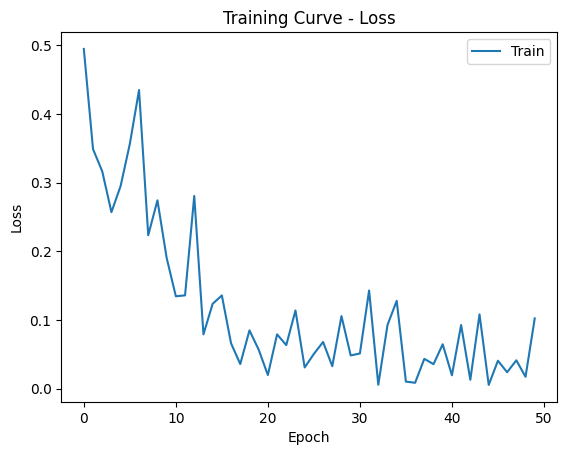

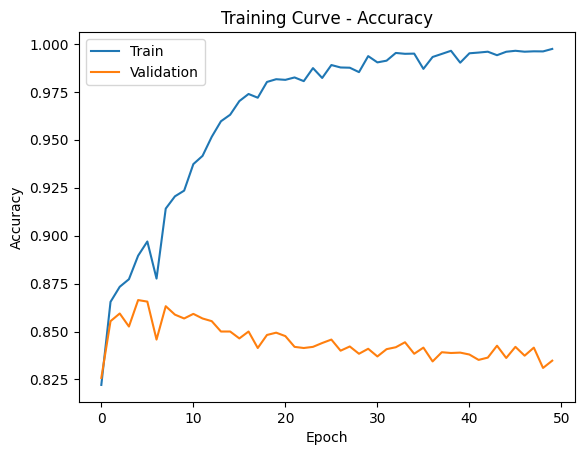

Validation Accuracy: 0.8348


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_type = SentimentRNN
vocab_size = len(stoi) + 1
output_size = 1
embedding_dim = 50
hidden_dim = 64
n_layers = 2
batch_size = 64
lr = 1e-3

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

model = model_type(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
model = model.to(device)
print(model)

train_rnn_network(model, train_loader, valid_loader, num_epochs=50, learning_rate=lr)

accuracy = get_accuracy(model, valid_loader)
print(f'Validation Accuracy: {accuracy:.4f}')

#Model 2

MPSentimentRNN(
  (embedding): Embedding(1001, 50)
  (lstm): LSTM(50, 64, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch 1; Loss 0.3362; Train Acc 0.8263; Val Acc 0.8292
Epoch 2; Loss 0.4008; Train Acc 0.8557; Val Acc 0.8448
Epoch 3; Loss 0.5292; Train Acc 0.8633; Val Acc 0.8458
Epoch 4; Loss 0.3028; Train Acc 0.8781; Val Acc 0.8524
Epoch 5; Loss 0.2855; Train Acc 0.8875; Val Acc 0.8496
Epoch 6; Loss 0.2893; Train Acc 0.8949; Val Acc 0.8486
Epoch 7; Loss 0.2355; Train Acc 0.9035; Val Acc 0.8470
Epoch 8; Loss 0.1948; Train Acc 0.9106; Val Acc 0.8492
Epoch 9; Loss 0.4423; Train Acc 0.9205; Val Acc 0.8462
Epoch 10; Loss 0.3841; Train Acc 0.9289; Val Acc 0.8432
Epoch 11; Loss 0.2308; Train Acc 0.9301; Val Acc 0.8348
Epoch 12; Loss 0.2742; Train Acc 0.9419; Val Acc 0.8356
Epoch 13; Loss 0.0822; Train Acc 0.9468; Val Acc 0.8356
Epoch 14; Loss 0.1656; Train Acc 0.9

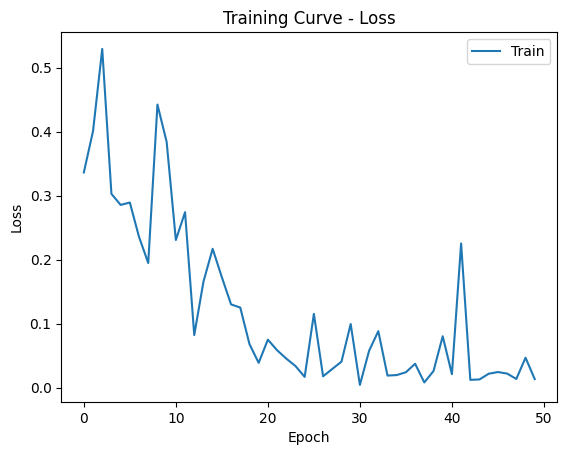

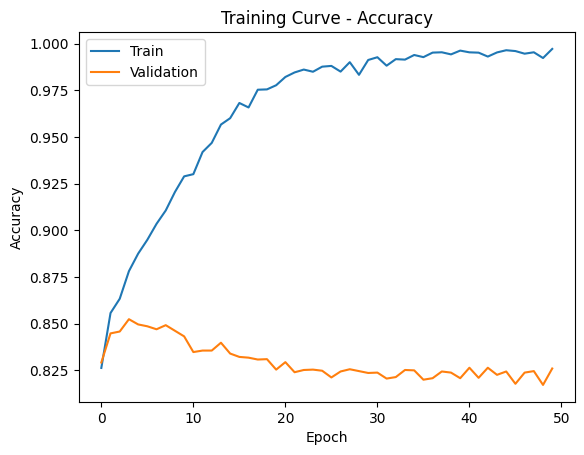

Validation Accuracy: 0.8260


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_type = MPSentimentRNN
vocab_size = len(stoi) + 1
output_size = 1
embedding_dim = 50
hidden_dim = 64
n_layers = 2
batch_size = 64
lr = 1e-3

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

model = model_type(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
model = model.to(device)
print(model)

train_rnn_network(model, train_loader, valid_loader, num_epochs=50, learning_rate=lr)

accuracy = get_accuracy(model, valid_loader)
print(f'Validation Accuracy: {accuracy:.4f}')

# Model 3

ConcatSentimentRNN(
  (embedding): Embedding(1001, 50)
  (lstm): LSTM(50, 64, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch 1; Loss 0.3653; Train Acc 0.8265; Val Acc 0.8156
Epoch 2; Loss 0.2381; Train Acc 0.8486; Val Acc 0.8316
Epoch 3; Loss 0.3304; Train Acc 0.8600; Val Acc 0.8368
Epoch 4; Loss 0.4131; Train Acc 0.8669; Val Acc 0.8356
Epoch 5; Loss 0.2202; Train Acc 0.8750; Val Acc 0.8422
Epoch 6; Loss 0.2365; Train Acc 0.8938; Val Acc 0.8520
Epoch 7; Loss 0.4032; Train Acc 0.9005; Val Acc 0.8480
Epoch 8; Loss 0.3147; Train Acc 0.9089; Val Acc 0.8522
Epoch 9; Loss 0.4055; Train Acc 0.9189; Val Acc 0.8472
Epoch 10; Loss 0.3845; Train Acc 0.9235; Val Acc 0.8450
Epoch 11; Loss 0.2427; Train Acc 0.9351; Val Acc 0.8476
Epoch 12; Loss 0.2994; Train Acc 0.9381; Val Acc 0.8368
Epoch 13; Loss 0.1570; Train Acc 0.9468; Val Acc 0.8418
Epoch 14; Loss 0.1552; Train Acc

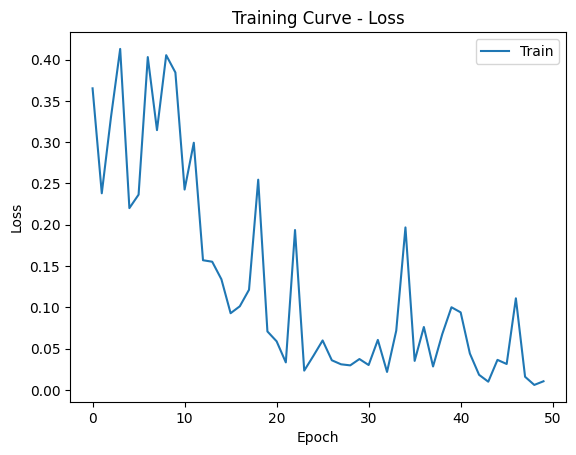

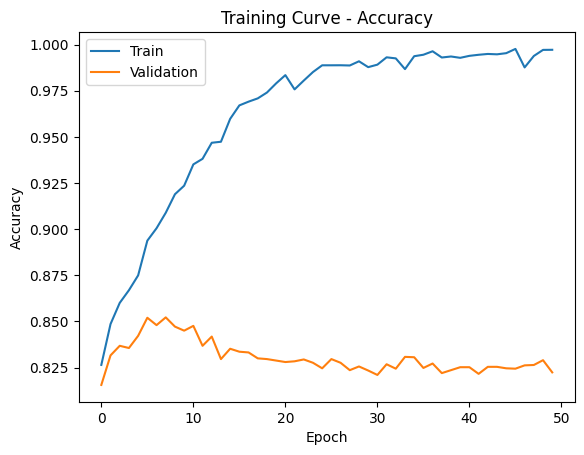

Validation Accuracy: 0.8224


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_type = ConcatSentimentRNN
vocab_size = len(stoi) + 1
output_size = 1
embedding_dim = 50
hidden_dim = 64
n_layers = 2
batch_size = 64
lr = 1e-3

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

model = model_type(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
model = model.to(device)
print(model)

train_rnn_network(model, train_loader, valid_loader, num_epochs=50, learning_rate=lr)

accuracy = get_accuracy(model, valid_loader)
print(f'Validation Accuracy: {accuracy:.4f}')

# Model 4

GloVeSentimentRNN(
  (embedding): Embedding(1001, 50)
  (lstm): LSTM(50, 64, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch 1; Loss 0.4976; Train Acc 0.7869; Val Acc 0.7886
Epoch 2; Loss 0.4112; Train Acc 0.8123; Val Acc 0.8144
Epoch 3; Loss 0.5943; Train Acc 0.8085; Val Acc 0.8082
Epoch 4; Loss 0.4166; Train Acc 0.8345; Val Acc 0.8294
Epoch 5; Loss 0.3385; Train Acc 0.8364; Val Acc 0.8246
Epoch 6; Loss 0.3855; Train Acc 0.8462; Val Acc 0.8336
Epoch 7; Loss 0.3990; Train Acc 0.8536; Val Acc 0.8338
Epoch 8; Loss 0.3380; Train Acc 0.8570; Val Acc 0.8402
Epoch 9; Loss 0.4117; Train Acc 0.8602; Val Acc 0.8408
Epoch 10; Loss 0.2941; Train Acc 0.8635; Val Acc 0.8396
Epoch 11; Loss 0.4928; Train Acc 0.8708; Val Acc 0.8400
Epoch 12; Loss 0.3334; Train Acc 0.8419; Val Acc 0.8156
Epoch 13; Loss 0.2903; Train Acc 0.8787; Val Acc 0.8386
Epoch 14; Loss 0.3749; Train Acc

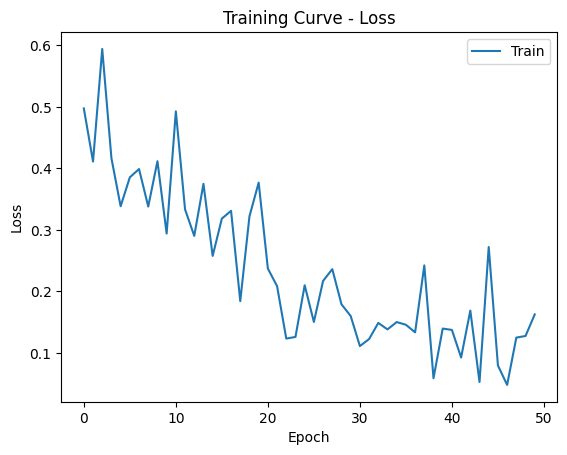

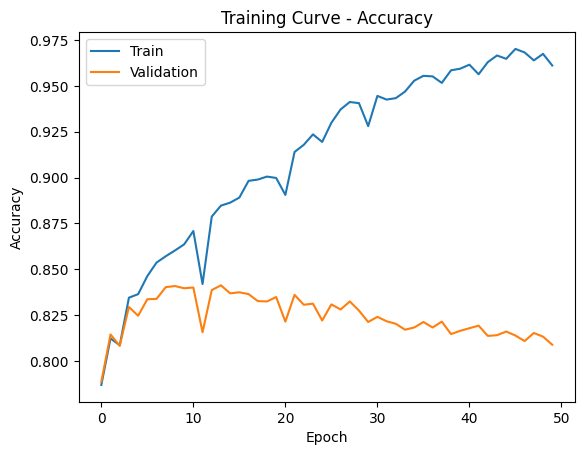

Validation Accuracy: 0.8088


In [ ]:
""" With GloVe embedding"""
model_type = GloVeSentimentRNN
vocab_size = len(stoi) + 1
output_size = 1
embedding_dim = 50
hidden_dim = 64
n_layers = 2
batch_size = 64
lr = 1e-3

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

model = model_type(vocab_size, output_size, embedding_dim, hidden_dim, n_layers,
                   glove_weights=embedding_matrix)
model = model.to(device)
print(model)
train_rnn_network(model, train_loader, valid_loader, num_epochs=50, learning_rate=lr)

accuracy = get_accuracy(model, valid_loader)
print(f'Validation Accuracy: {accuracy:.4f}')

In the next part, we will tune model 3. While Models 1 and 2 reached higher validation accuracies, due to the gap between the training and validation accuracies, especially in later epochs, they exhibit sinificant overfitting. Model 4 on the other hand exhibited the opposite problem - it had a lower peak in training accuracy compared to the other models which might suggest less overfitting however, it's peak validation accuracy was also lower than the other models. While this model seems to generalize better, it is at the cost of overall performance. Model 3 shows more consistent performance and although there is still some evidence of overfitting, it is less pronounced compared to the other models.

### Part (iii)

Tuning hyperparameters.

1. **Learning Rate**

  This is a crucial hyperparameter for training neural networks. A learning rate that's too high can cause the model to converge too quickly to a suboptimal solution, while a rate that's too low can make the training process unnecessarily long and prone to getting stuck in local minima.

  Here I decreased the learning rate because when I ran ConcatSentimentRNN above, the model exhibited some overfitting. We want the model to generalize better so the learning rate was decreased from 0.001 to 0.0001

ConcatSentimentRNN(
  (embedding): Embedding(1001, 50)
  (lstm): LSTM(50, 64, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch 1; Loss 0.6911; Train Acc 0.6184; Val Acc 0.6148
Epoch 2; Loss 0.5273; Train Acc 0.7410; Val Acc 0.7396
Epoch 3; Loss 0.4639; Train Acc 0.7768; Val Acc 0.7738
Epoch 4; Loss 0.3631; Train Acc 0.7993; Val Acc 0.7964
Epoch 5; Loss 0.4069; Train Acc 0.8164; Val Acc 0.8090
Epoch 6; Loss 0.3589; Train Acc 0.8281; Val Acc 0.8158
Epoch 7; Loss 0.3064; Train Acc 0.8335; Val Acc 0.8226
Epoch 8; Loss 0.4122; Train Acc 0.8414; Val Acc 0.8306
Epoch 9; Loss 0.4448; Train Acc 0.8459; Val Acc 0.8332
Epoch 10; Loss 0.3405; Train Acc 0.8498; Val Acc 0.8350
Epoch 11; Loss 0.3994; Train Acc 0.8514; Val Acc 0.8356
Epoch 12; Loss 0.3674; Train Acc 0.8529; Val Acc 0.8342
Epoch 13; Loss 0.4126; Train Acc 0.8599; Val Acc 0.8382
Epoch 14; Loss 0.4994; Train Acc

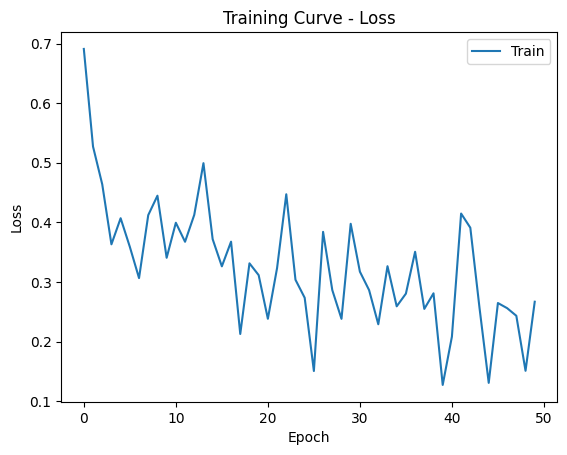

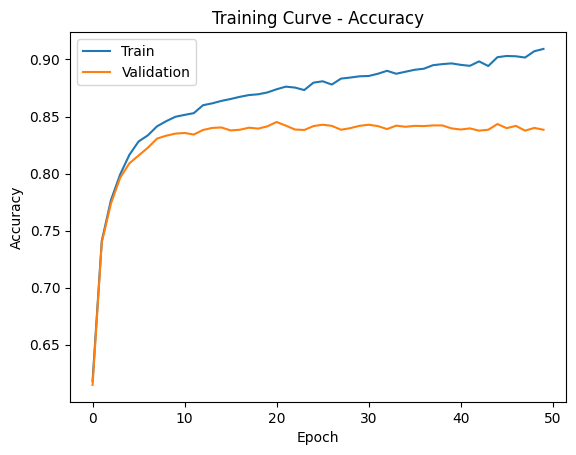

Validation Accuracy: 0.8384


In [ ]:
# TO BE COMPLETED
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_type = ConcatSentimentRNN
vocab_size = len(stoi) + 1
output_size = 1
embedding_dim = 50
hidden_dim = 64
n_layers = 2
batch_size = 64
lr = 1e-4

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

model = model_type(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
model = model.to(device)
print(model)

train_rnn_network(model, train_loader, valid_loader, num_epochs=50, learning_rate=lr)

accuracy = get_accuracy(model, valid_loader)
print(f'Validation Accuracy: {accuracy:.4f}')

  Lower training accuracy compared to the previous setting but a slightly improved validation accuracy. The gap between training and validation accuracy is reduced, indicating better generalization.

2. **Batch Size**

  This impacts the model's stochastic gradient descent process. A smaller batch size often provides a regularizing effect and lower generalization error. However, it can make the training process noisier and longer. Conversely, a larger batch size allows for more stable and faster training but can lead to overfitting.

  Since we previously saw some overfitting, we will also decrease the batch size to 32.

ConcatSentimentRNN(
  (embedding): Embedding(1001, 50)
  (lstm): LSTM(50, 64, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch 1; Loss 0.5601; Train Acc 0.6758; Val Acc 0.6814
Epoch 2; Loss 0.6172; Train Acc 0.7723; Val Acc 0.7812
Epoch 3; Loss 0.4807; Train Acc 0.8092; Val Acc 0.8142
Epoch 4; Loss 0.2767; Train Acc 0.8195; Val Acc 0.8196
Epoch 5; Loss 0.5378; Train Acc 0.8321; Val Acc 0.8306
Epoch 6; Loss 0.3139; Train Acc 0.8422; Val Acc 0.8354
Epoch 7; Loss 0.2885; Train Acc 0.8468; Val Acc 0.8334
Epoch 8; Loss 0.4051; Train Acc 0.8513; Val Acc 0.8346
Epoch 9; Loss 0.3220; Train Acc 0.8586; Val Acc 0.8406
Epoch 10; Loss 0.3002; Train Acc 0.8597; Val Acc 0.8390
Epoch 11; Loss 0.3040; Train Acc 0.8668; Val Acc 0.8430
Epoch 12; Loss 0.4722; Train Acc 0.8682; Val Acc 0.8434
Epoch 13; Loss 0.2541; Train Acc 0.8656; Val Acc 0.8368
Epoch 14; Loss 0.1732; Train Acc

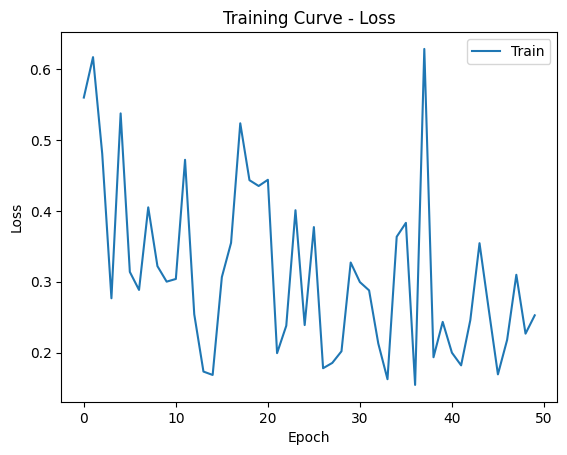

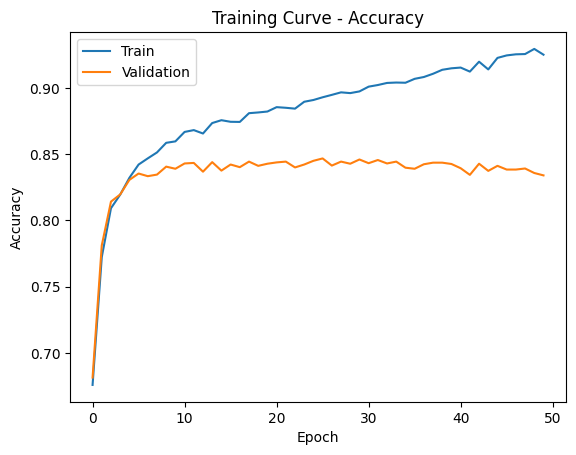

Validation Accuracy: 0.8340


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_type = ConcatSentimentRNN
vocab_size = len(stoi) + 1
output_size = 1
embedding_dim = 50
hidden_dim = 64
n_layers = 2
batch_size = 32
lr = 1e-4

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

model = model_type(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
model = model.to(device)
print(model)

train_rnn_network(model, train_loader, valid_loader, num_epochs=50, learning_rate=lr)

accuracy = get_accuracy(model, valid_loader)
print(f'Validation Accuracy: {accuracy:.4f}')

  Changing the batch size from 64 to 32 with a lower learning rate showed a slight decrease in validation accuracy. This might be due to the model receiving more frequent updates, which can sometimes lead to overfitting.

3. **LSTM Hidden Dimension (hidden_dim)**

 The hidden dimension size directly influences the capacity of the LSTM to capture info in the sequence. SInce the dataset has some lengthy reviews, a larger hidden dimension might capture more nuanced information, but it also increases the risk of overfitting and computational cost. We must balance this trade-off.

  We will increase this to 128. This is because a higher hidden_dim provides the model with more capacity to learn from the data. Given the complexity of natural language, especially in longer text sequences, a larger hidden dimension can be beneficial.

  For now we will do this with the higher batch_size of 64 due to the results of the last previous training, and to avoid excessively long training time.

ConcatSentimentRNN(
  (embedding): Embedding(1001, 50)
  (lstm): LSTM(50, 128, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch 1; Loss 0.5784; Train Acc 0.7086; Val Acc 0.7026
Epoch 2; Loss 0.4922; Train Acc 0.7673; Val Acc 0.7626
Epoch 3; Loss 0.3766; Train Acc 0.8081; Val Acc 0.8026
Epoch 4; Loss 0.4555; Train Acc 0.8204; Val Acc 0.8136
Epoch 5; Loss 0.3232; Train Acc 0.8349; Val Acc 0.8268
Epoch 6; Loss 0.3827; Train Acc 0.8420; Val Acc 0.8338
Epoch 7; Loss 0.2653; Train Acc 0.8485; Val Acc 0.8328
Epoch 8; Loss 0.3854; Train Acc 0.8486; Val Acc 0.8356
Epoch 9; Loss 0.5092; Train Acc 0.8498; Val Acc 0.8316
Epoch 10; Loss 0.4381; Train Acc 0.8587; Val Acc 0.8442
Epoch 11; Loss 0.2501; Train Acc 0.8637; Val Acc 0.8422
Epoch 12; Loss 0.3180; Train Acc 0.8586; Val Acc 0.8414
Epoch 13; Loss 0.3985; Train Acc 0.8637; Val Acc 0.8438
Epoch 14; Loss 0.3132; Train A

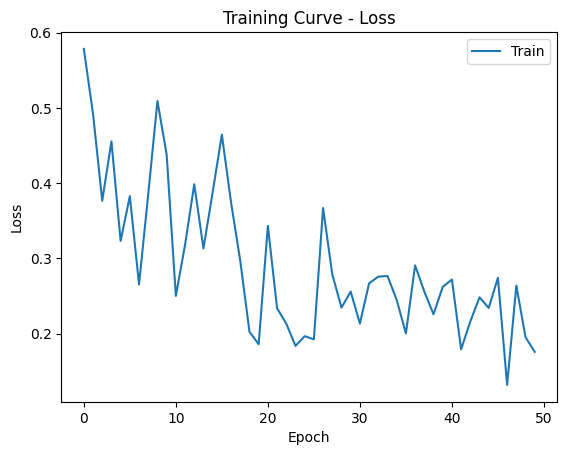

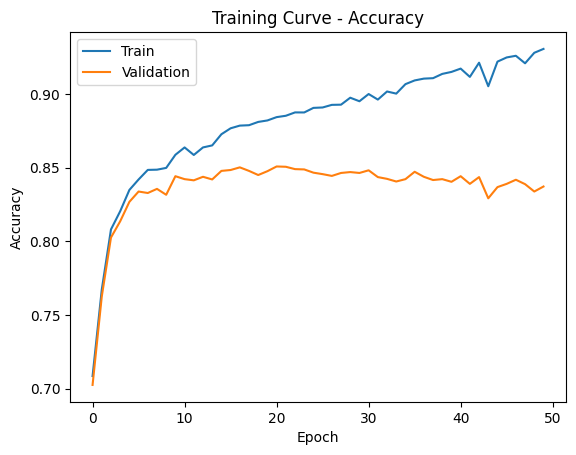

Validation Accuracy: 0.8372


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_type = ConcatSentimentRNN
vocab_size = len(stoi) + 1
output_size = 1
embedding_dim = 50
hidden_dim = 128
n_layers = 2
batch_size = 64
lr = 1e-4

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

model = model_type(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
model = model.to(device)
print(model)

train_rnn_network(model, train_loader, valid_loader, num_epochs=50, learning_rate=lr)

accuracy = get_accuracy(model, valid_loader)
print(f'Validation Accuracy: {accuracy:.4f}')

Towards the later epochs, there's a possibility that the model might be overfitting. This can be inferred since the training accuracy continues to increase while the validation accuracy stagnates and then decreases. Overfitting occurs when the model learns patterns specific to the training data, which do not generalize well to unseen data. The increase in the hidden dimension size may have introduced more complexity than necessary, potentially leading to overfitting.

4. **Number of LSTM Layers (n_layers)**

  More layers can increase the model's ability to capture complex patterns (like higher-level semantic meanings), but similar to the hidden dimension, more layers can also lead to overfitting and longer training times.

  For now we will try 3 layers. We will set hidden dim back to 64 since the last training loop took a long time to train (19 mins) without a significant increase in validation accuracy.

ConcatSentimentRNN(
  (embedding): Embedding(1001, 50)
  (lstm): LSTM(50, 64, num_layers=3, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch 1; Loss 0.6986; Train Acc 0.4990; Val Acc 0.5002
Epoch 2; Loss 0.5949; Train Acc 0.6745; Val Acc 0.6654
Epoch 3; Loss 0.5263; Train Acc 0.7488; Val Acc 0.7406
Epoch 4; Loss 0.5369; Train Acc 0.7857; Val Acc 0.7798
Epoch 5; Loss 0.3665; Train Acc 0.8091; Val Acc 0.8028
Epoch 6; Loss 0.4901; Train Acc 0.8211; Val Acc 0.8172
Epoch 7; Loss 0.3360; Train Acc 0.8288; Val Acc 0.8190
Epoch 8; Loss 0.4026; Train Acc 0.8376; Val Acc 0.8248
Epoch 9; Loss 0.4826; Train Acc 0.8412; Val Acc 0.8338
Epoch 10; Loss 0.4562; Train Acc 0.8447; Val Acc 0.8302
Epoch 11; Loss 0.4206; Train Acc 0.8490; Val Acc 0.8356
Epoch 12; Loss 0.3496; Train Acc 0.8527; Val Acc 0.8390
Epoch 13; Loss 0.4198; Train Acc 0.8534; Val Acc 0.8334
Epoch 14; Loss 0.3874; Train Acc

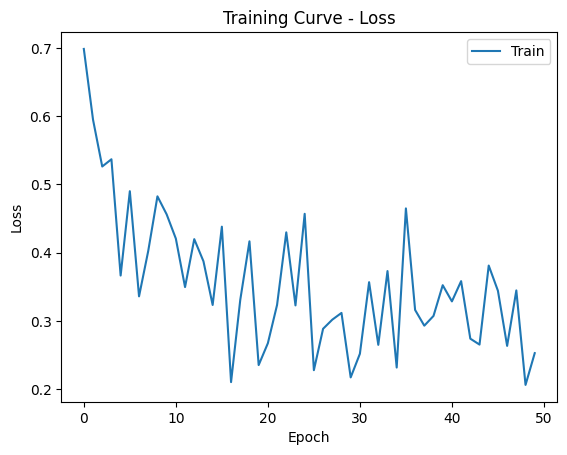

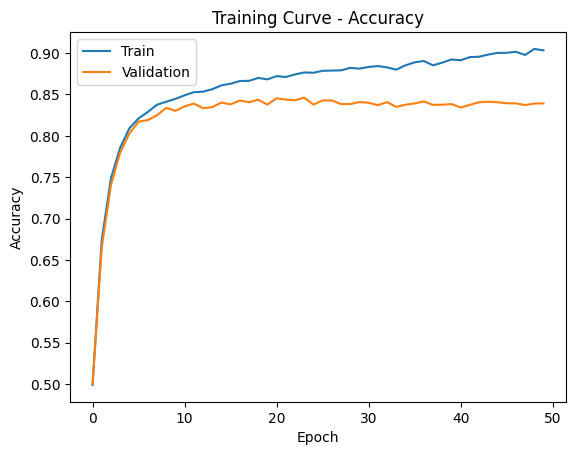

Validation Accuracy: 0.8392


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_type = ConcatSentimentRNN
vocab_size = len(stoi) + 1
output_size = 1
embedding_dim = 50
hidden_dim = 64
n_layers = 3
batch_size = 64
lr = 1e-4

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

model = model_type(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
model = model.to(device)
print(model)

train_rnn_network(model, train_loader, valid_loader, num_epochs=50, learning_rate=lr)

accuracy = get_accuracy(model, valid_loader)
print(f'Validation Accuracy: {accuracy:.4f}')

The training accuracy gradually increases over epochs, suggesting that the model is learning effectively from the training dataset. However, the validation accuracy also increases but plateaus and oscillates around certain values, indicating some degree of overfitting.

5. **Sequence Length for Padding (seq_len)**

  Given the variance in review lengths, this parameter is crucial. Too short a length might truncate valuable information, especially for longer reviews, while too long a length can increase computational load and might introduce more noise from shorter reviews. This needs to be tuned considering the average and median review lengths.

  The average and median review lengths are around 1300 and 970 characters, respectively. The current sequence length of 500 might be truncating too much valuable information. Increasing it to 800-1000 could capture more relevant content from the reviews, especially considering that the longer reviews tend to be more positively biased. For now we will increase to 900.

In [ ]:
new_seq_len = 900

new_X_train_padded = padding_(X_train_encoded, new_seq_len)
new_X_valid_padded = padding_(X_valid_encoded, new_seq_len)
new_X_test_padded = padding_(X_test_encoded, new_seq_len)

In [ ]:
n_X_train_tensor = torch.tensor(new_X_train_padded, dtype=torch.long)
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.float32)
n_X_valid_tensor = torch.tensor(new_X_valid_padded, dtype=torch.long)
y_valid_tensor = torch.tensor(y_valid_encoded, dtype=torch.float32)

In [ ]:
train_dataset_new = TensorDataset(n_X_train_tensor, y_train_tensor)
valid_dataset_new = TensorDataset(n_X_valid_tensor, y_valid_tensor)

ConcatSentimentRNN(
  (embedding): Embedding(1001, 50)
  (lstm): LSTM(50, 64, num_layers=3, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch 1; Loss 0.6918; Train Acc 0.5010; Val Acc 0.4998
Epoch 2; Loss 0.5970; Train Acc 0.7450; Val Acc 0.7420
Epoch 3; Loss 0.3986; Train Acc 0.7813; Val Acc 0.7790
Epoch 4; Loss 0.5131; Train Acc 0.7963; Val Acc 0.7882
Epoch 5; Loss 0.5166; Train Acc 0.8172; Val Acc 0.8056
Epoch 6; Loss 0.3620; Train Acc 0.8279; Val Acc 0.8160
Epoch 7; Loss 0.4746; Train Acc 0.8336; Val Acc 0.8230
Epoch 8; Loss 0.3364; Train Acc 0.8389; Val Acc 0.8266
Epoch 9; Loss 0.2910; Train Acc 0.8445; Val Acc 0.8272
Epoch 10; Loss 0.3388; Train Acc 0.8485; Val Acc 0.8326
Epoch 11; Loss 0.2313; Train Acc 0.8510; Val Acc 0.8332
Epoch 12; Loss 0.4112; Train Acc 0.8528; Val Acc 0.8316
Epoch 13; Loss 0.3346; Train Acc 0.8579; Val Acc 0.8372
Epoch 14; Loss 0.3074; Train Acc

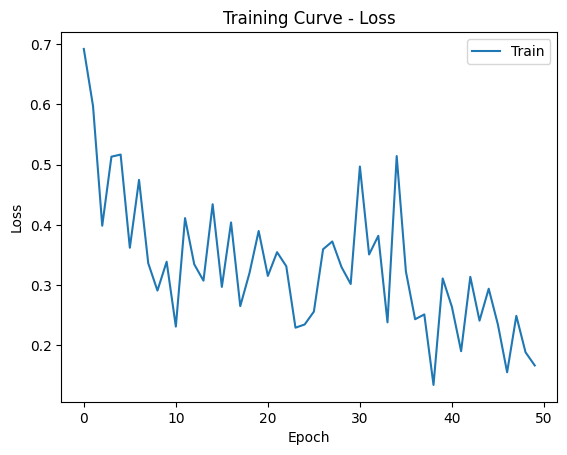

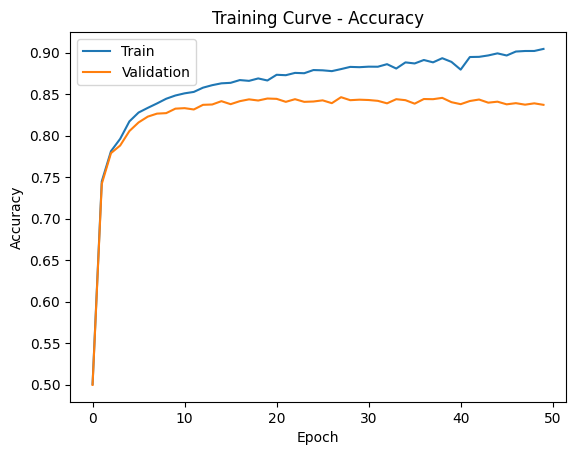

Validation Accuracy: 0.8372


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_type = ConcatSentimentRNN
vocab_size = len(stoi) + 1
output_size = 1
embedding_dim = 50
hidden_dim = 64
n_layers = 3
batch_size = 64
lr = 1e-4

train_loader_new = DataLoader(train_dataset_new, batch_size=batch_size, shuffle=True)
valid_loader_new = DataLoader(valid_dataset_new, batch_size=batch_size, shuffle=False)

model_best = model_type(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
model_best = model_best.to(device)
print(model_best)

train_rnn_network(model_best, train_loader_new, valid_loader_new, num_epochs=50, learning_rate=lr)

accuracy = get_accuracy(model_best, valid_loader_new)
print(f'Validation Accuracy: {accuracy:.4f}')

The model demonstrates a steady increase in training and validation accuracy over 50 epochs, which indicates that it is learning effectively from the training data. The model's performance on the validation set is consistent with training performance, suggesting a good balance between learning and generalization. There's no significant overfitting observed.

6. **Increase Dropout Rate**
  
   The current dropout rate is 0.5, we will increase it to a higher value of 0.65. A higher dropout rate can help reduce overfitting by randomly turning off a larger portion of neurons during the training process. This forces the network to learn more robust features that are useful in conjunction with many different random subsets of the other neurons.

   Since we saw an increase in performance in the previous training loop, we will use the seq_len of 1000 and we will try to run the training loop with the smaller batch sizes of 32.

In [ ]:
class ConcatSentimentRNNDrop(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.65):
        super(ConcatSentimentRNNDrop, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers,
                            dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, hidden):
        batch_size = x.size(0)
        x = x.long()
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
        lstm_out, _ = torch.max(lstm_out, dim=1)

        out = self.dropout(lstm_out)
        out = self.fc(out)
        out = self.sigmoid(out)

        return out, hidden

    def init_hidden(self, batch_size):
        """
        Initializes hidden state
        """
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())

        return hidden

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_type = ConcatSentimentRNNDrop
vocab_size = len(stoi) + 1
output_size = 1
embedding_dim = 50
hidden_dim = 64
n_layers = 3
batch_size =
lr = 1e-4

train_loader = DataLoader(train_dataset_new, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset_new, batch_size=batch_size, shuffle=False)

model = model_type(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
model = model.to(device)
print(model)

train_rnn_network(model, train_loader, valid_loader, num_epochs=50, learning_rate=lr)

accuracy = get_accuracy(model, valid_loader)
print(f'Validation Accuracy: {accuracy:.4f}')

 When I ran this, there was a significant gap between training and validation accuracy which suggests that the model might be overfitting the training data. While it performs well on the data it has seen, it doesn't generalize as effectively to new, unseen data.

## Part 4. Evaluation

**Important**.

### Part (i)



>   We will use our best model with the following parameters:
  * model_type = ConcatSentimentRNN
  * vocab_size = len(stoi) + 1
  * output_size = 1
  * embedding_dim = 50
  * hidden_dim = 64
  * n_layers = 3
  * batch_size = 64
  * lr = 1e-4

In [ ]:

X_test_tensor = torch.tensor(new_X_test_padded, dtype=torch.long) # this uses padding of the seq len of 1000
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.float32)

In [ ]:
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
def evaluate_model_and_collect_misclassified(model, data_loader, original_data):
    """ Evaluates model and collects misclassified examples from the test set """
    model.eval()
    correct, total = 0, 0
    misclassified = []

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(data_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            batch_size = inputs.size(0)
            hidden = model.init_hidden(batch_size)
            output, _ = model(inputs, hidden)
            predicted = (output.squeeze() >= 0.5).float()

            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            start_idx = i * batch_size
            mismatches = predicted != labels
            if mismatches.any():
                mismatches_indices = mismatches.nonzero(as_tuple=False).squeeze()
                # Check if mismatches_indices is a 0-dimensional tensor
                if mismatches_indices.dim() == 0:
                    mismatches_indices = mismatches_indices.unsqueeze(0)
                for idx in mismatches_indices:
                    original_idx = start_idx + idx.item()
                    misclassified_review = original_data[original_idx]
                    true_label = labels[idx].item()
                    predicted_label = predicted[idx].item()
                    misclassified.append((misclassified_review, true_label, predicted_label))

    accuracy = correct / total
    return accuracy, misclassified

In [ ]:
print(model_best)
test_accuracy, misclassified_examples = evaluate_model_and_collect_misclassified(model_best, test_loader, X_test)
print(f'Test Accuracy: {test_accuracy:.4f}')

ConcatSentimentRNN(
  (embedding): Embedding(1001, 50)
  (lstm): LSTM(50, 64, num_layers=3, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Test Accuracy: 0.8380


Train Acc 0.8990, Val Acc 0.8372, Test Accuracy: 0.8380

The test accuracy is very close to the validation accuracy, which is a good sign. The test dataset is used to give an unbiased evaluation of the final model fit. The fact that the test accuracy is close to the validation accuracy suggests that the model generalizes well and is not overfitting significantly to the training data.

### Part (ii)

Next I will look over the misclassified samples in the test data to see if I can find any patterns on where the model has difficulty with identifying the review sentiment.

In [ ]:
pd.set_option('display.max_colwidth', None)

def create_misclassified_dataframe(misclassified_examples, num_examples=5):
    data = []
    for review, true_label, predicted_label in misclassified_examples[:num_examples]:
        # Slice the first 100 characters of the review
        review_snippet = review[:200] + "..." if len(review) > 200 else review
        entry = {
            "Review": review_snippet,
            "True Label": 'Positive' if true_label == 1 else 'Negative',
            "Predicted Label": 'Positive' if predicted_label >= 0.5 else 'Negative'
        }
        data.append(entry)

    return pd.DataFrame(data)

In [ ]:
import pandas as pd

pd.set_option('display.max_colwidth', None)

def create_misclassified_dataframe(misclassified_examples, num_examples=50):
    data = []
    for review, true_label, predicted_label in misclassified_examples[:num_examples]:
        entry = {
            "Review": review,
            "True Label": 'Positive' if true_label == 1 else 'Negative',
            "Predicted Label": 'Positive' if predicted_label >= 0.5 else 'Negative'
        }
        data.append(entry)

    return pd.DataFrame(data)

In [ ]:
positive_misclassified = [example for example in misclassified_examples if example[1] == 1]
positive_df = create_misclassified_dataframe(positive_misclassified)
print("Positive Misclassified Examples:")
positive_df

Positive Misclassified Examples:


""


**Positive Reviews Misclassified as Negative**

* Reviews that contain subtle positive sentiments or sarcasm can be challenging for models to classify correctly. For instance, the first review praises a show using a somewhat sarcastic tone, which might be misinterpreted as negative by the model.
> "The entire civilized world by now knows.."

* Reviews that contain a mix of positive and negative sentiments can confuse the model. The second review, for example, starts by criticizing the film's premise but then acknowledges its enjoyable aspects. This mix might lead to misclassification.
> "While the premise of the film is pretty lame"


 * Some reviews express sentiments in complex ways, such as through detailed descriptions or references to specific aspects of a movie or show. These nuances might be missed by the model, leading to incorrect classification.

* Reviews that require a deep understanding of the context or background (like specific knowledge about a film series or a genre) may not be accurately assessed by the model. SImilarily reviews with specific references to characters, scenes, or industry jargon could be challenging for the model. The fourth and fifth reviews include specific references that might not be recognized as positive.
>"At least for a half hour a week. I haven't been interested in anything on the big 3 networks (ABC/CBS/NBC) in years."

In [ ]:
negative_misclassified = [example for example in misclassified_examples if example[1] == 0]
negative_df = create_misclassified_dataframe(negative_misclassified)
print("\nNegative Misclassified Examples:")
negative_df


Negative Misclassified Examples:


,Review,True Label,Predicted Label
0,"Wow!!! I have been looking forward to this since the book came out, \nhoping it would be turned into a movie! They truly knew what to keep in the movie, \nwhat to adapt and what to leave in the book. Absolutely fantastic! I'm so happy and \nI loved every second of it. The actors did an amazing portrayal of the characters\n and the movie had great pacing and flow. As soon as it finished I would have\n happily stayed in my seat for a second viewing. You could watch this as a \n standalone but you do get more out of it if you have seen the other movies. \n You can see all the ground work and you get insight into many characters as \n well as the creation of the system and how it grew to be what we see in The \n Hunger Games.",Negative,Positive
1,"I may consider myself lucky to be alive to watch Christopher Nolan \nWorks which get better by years. Oppenheimer is - with no doubt- going to be one \nof the best movies in the history. Amazing cinematography, Exceptional acting and \nterrifying Soundtracks. All the cast are great from cilian Murphy who is going \nfor the oscar with this role to Rupert Downey jr and Emily blunt and finally rami \nmalik who has small scenes but you will never forget them. I didn't watch it in \nImax as i couldn't wait and ran to the nearest cinema but now i will sure book an \nimax ticket. Don't waste any time, book your ticket and Go watch it.. NOW.",Negative,Positive
2,"I'm still collecting my thoughts after experiencing this film, Cillian \nMurphy might as well start clearing a space on his mantle for the Best Actor Oscar.\n This film is a masterclass in weaving narratives and different time periods \n while exploring the profound depths of a man whose actions altered the world's \n trajectory forever, for better or worse. Nolan brings us into the complexities\n of Oppenheimer, and all the moral conflicts stirring within him.Murphy's portrayal\n is so riveting that the long run-time became an afterthought. Robert Downey Jr\n also offers a great performance and Nolan's push and pull with how he uses \n sound design throughout is the cherry on top. Some viewers might need a brief\n refresher on WWII and Cold War history, but any film lover should be happy to \n willingly lose themselves in this film for hours on end.",Negative,Positive
3,"As much as it pains me to give a movie called ""Barbie"" a 10 out of 10,\n I have to do so. It is so brilliantly handled and finely crafted, I have to give\n the filmakers credit. Yes, I am somewhat conservative person and former law\n enforcement officer. I'm a guy. I like guy things. Hell I even enjoyed the \n Battleship movie a few years ago (an absolutely ridiculous but fun romp of an\n action film). But I also like to experience other perspectives. And man oh \n man does this movie deliver that in spades - pretty much encapsulated \n everything my wife has tried to convey about her entire career and life \n experience wrapped up into two hours! The humor, the sets, the acting, and \n the ability to weave the current narrative into the story was just perfect. \n I don't agree with some of the points of the movie, but again, that's ok. \n This movie wasn't designed to give a balanced perspective of men versus women;\n it is a no-holds-barred unapologetic crazy ride of a rant about the real \n issues that women have faced since they were ""allowed"" to have ""real jobs"" \n and do the same things as men. Give me a well done film that is a blast to \n watch, that makes you think, and that was done from a place of creativity, \n passion, and attention to detail, and I'll call it what it is: a 10 out of \n 10 masterpiece.",Negative,Positive




**Negative Reviews Misclassified as Positive**
* Some reviews may express criticism indirectly or in a less straightforward manner. For instance, the first review, while primarily negative, starts by mentioning some positives, which might mislead the model.
> "I'm glad I rented this movie for one reason... "

* Reviews that use irony or sarcasm to convey negative sentiments can be difficult for models to interpret correctly. The second review, for example, uses a sarcastic tone to criticize the movie.
> "...And you'd be right..."

* Reviews that go into detail about why a movie is bad, but without using overtly negative language, can be misclassified. The third review, for example, criticizes the movie but in a kind of subdued manner.
> "This movie is pretty predictable nuff said....from the delayed kissing scene to the inevitable coming around of grandpa...this is a great movie for the 10-12 age group but beyond that..."

*  Negative reviews that are rich in narrative or descriptive language might be misinterpreted by the model. Some negative reviews also might focus more on analysis than direct critique. This analytical approach can mask a negative tone. For example, the final review focuses on anaysing the film in the context of the director's previous work.
> "Is this the same Kim Ki Duk who directed the poignant, life-spanning testimonial of "Spring, Summer, Fall, Winter and Spring"? "

### Part (iii)



In [ ]:
review = """Man.... I wish I loved this movie more than I did. Don't get me wrong,
it's a solid action movie with jaw-dropping stunts (some of the best in the series),
but as a Mission: Impossible movie, it felt like a small step backward for the franchise.
Fallout had mind-blowing action sequences and stunt work, along with developing Ethan's
relationship with Ilsa, providing closure with Julia, showing the lengths Ethan would
go to protect those closest to him, and battling an imposing villain. Dead Reckoning:
Part One stretches the movie across two films only to seemingly showcase action
spectacle after action spectacle while sacrificing character development.
Characters I have grown to love over a decade of films felt sidelined, ignored,
or wasted. Hayley Atwell's new character chewed up most of the screen time, and
while she was fantastic, I wanted to see more of the original team. The new villain
had an inconsistent ability that confused more than intimidated. There were some
important emotional moments that I just didn't feel the weight of when I definitely
should have. Part Two might tie everything together and make me enjoy Part One
more in retrospect, but unfortunately, I left wanting more from this one. """

In [ ]:
def preprocess_review(review, stoi, seq_len):
    review_tokenized = [stoi[word] for word in preprocess_sentence(review) if word in stoi.keys()]
    review_padded = np.zeros(seq_len, dtype=int)
    review_padded[-len(review_tokenized):] = np.array(review_tokenized)[:seq_len]
    return review_padded

preprocessed_review = preprocess_review(review, stoi, seq_len=900)

In [ ]:
# Convert to tensor
review_tensor = torch.tensor([preprocessed_review], dtype=torch.long).to(device)

# Predict using the model
model.eval()
with torch.no_grad():
    hidden = model.init_hidden(1)
    prediction, _ = model(review_tensor, hidden)
    probability_positive = prediction.item()

print(f"Probability of being a positive review: {probability_positive:.4f}")

Probability of being a positive review: 0.9999


<ipython-input-81-f632497f9fad>:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  review_tensor = torch.tensor([preprocessed_review], dtype=torch.long).to(device)


### Part (iv)

Do you think that detecting positive and negative reviews is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**


Detecting positive and negative reviews can be a difficult task. The difficulty depends on several factors, including the complexity of language used in reviews, the presence of sarcasm or subtle sentiments, and the diversity of topics and expressions in the dataset. It is a challenging task due to nuances in human language and the potential variability in how sentiments are expressed.

For a baseline model to compare with a more complex recurrent neural network (RNN) model, the key is to create something simpler and less resource-intensive to serve as a reference point to understand whether the additional complexity and cost of the RNN are justified.

**Suggestion 1 - Rule-based Sentiment Analysis:**

We can develop a set of rules to classify reviews as positive or negative based on the presence of certain keywords. For instance, words like "excellent" and "amazing" could be indicators of a positive review, whereas "poor" and "terrible" might indicate negative sentiment.To do this, we need to create a dictionary of positive and negative words. For each review, we count the number of words that fall into each category and then we classify the review based on which type of word is more frequent. The main limitation of this approach is that it might miss nuances and context. For instance, it wouldn't handle negations ("not good") or sarcasm effectively.



**SUggestion 2 - Simple Neural Network:**

A basic feedforward neural network with one or two hidden layers. We can represent reviews by transforming text data into numerical form using word embeddings like GloVe. We can preprocess the reviews similar to what we have done above.

The input layer size will depend on the data representation. I.e., if we're using fixed-length word embedding vectors, the input size will be the length of these vectors. We can start with one or fully connected layers. The number of neurons in these layers can be tuned ofcourse - more neurons will capture complex patterns but also increase the risk of overfitting.


We can use 'ReLU' (Rectified Linear Unit) for hidden layers to help with the vanishing gradient problem and speeds up training. Since this is a binary classification problem (positive or negative sentiment), the output layer will have a single neuron with a 'sigmoid' activation function to output a probability.

For the loss function we can use 'binary crossentropy' since it is suitable for binary classification problems. FOr optimizer we can use Adam.

The problem with this simple model is that it probably will not not capture the sequential dependencies in the text data as well as RNNs.

# PART B - Transfer Learning



In [ ]:
# install relevant libraries
!pip install -qq transformers

In [ ]:
# load relevant libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
torch.cuda.empty_cache()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
sample_txt = 'I want to learn how to do sentiment analysis using BERT and tokenizer.'

encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
  truncation = True
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
encoding['input_ids']

tensor([[  101,   146,  1328,  1106,  3858,  1293,  1106,  1202, 17024,  3622,
          1606,   139,  9637,  1942,  1105, 22559, 17260,   119,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0]])

In [ ]:
encoding['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
hidden_states = bert_model(input_ids=encoding['input_ids'],
                           attention_mask=encoding['attention_mask'])[0]
pooled_output = bert_model(input_ids=encoding['input_ids'],
                           attention_mask=encoding['attention_mask'])[1]

In [ ]:
hidden_size = bert_model.config.hidden_size

print(hidden_size)
print(hidden_states.shape)
print(pooled_output.shape)

768
torch.Size([1, 32, 768])
torch.Size([1, 768])


In the sample code provided we loaded a short text sequence, tokenized it using the same tokenization that was used in the pretrained BERT model, and fed the tokenized input into the BERT model to obtain the embeddings.

The model output consists of two forms of embeddings:
- **hidden_states** are the final layer of outputs that has a shape sequence_length x embeddings, much like the hidden states of a recurrent neural network
- **pooled_output** is the result of applying max pooling on the hidden states to effectively collapse the sequence dimenension and ensure the same output size for any given sequence before feeding into the classification stage

Note that you can preprocess all of the data prior to training a classifier stage for sentiment analysis to help speed up the training process. This is no different from the process we applied in an earlier assignment using AlexNet and image data.

## Part 1. Data Loading


### Part (i)


In [ ]:
from torch.utils.data import Dataset, DataLoader

class MovieReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
      truncation = True
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
X_train, X_remaining, y_train, y_remaining = train_test_split(X, y, test_size=0.2, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_remaining, y_remaining, test_size=0.5, random_state=42)

In [ ]:
# Creating DataFrames validation and test datasets
df_train = pd.DataFrame({'review': X_train, 'sentiment': y_train})
df_valid = pd.DataFrame({'review': X_valid, 'sentiment': y_valid})
df_test = pd.DataFrame({'review': X_test, 'sentiment': y_test})

# Sentiment labels to numerical values for BERT
sentiment_mapping = {"positive": 1, "negative": 0}
df_train['sentiment'] = df_train['sentiment'].map(sentiment_mapping)
df_valid['sentiment'] = df_valid['sentiment'].map(sentiment_mapping)
df_test['sentiment'] = df_test['sentiment'].map(sentiment_mapping)

In [ ]:
# prepare data loaders
MAX_LEN = 400
BATCH_SIZE = 8

#training data
train_data = MovieReviewDataset(reviews=df_train['review'].to_numpy(),
                                targets=df_train['sentiment'].to_numpy(),
                                tokenizer=tokenizer,
                                max_len=MAX_LEN)

train_data_loader = DataLoader(train_data, batch_size = BATCH_SIZE, num_workers = 4) #modify num_works as needed

#validation data

valid_data = MovieReviewDataset(
    reviews=df_valid['review'].to_numpy(),
    targets=df_valid['sentiment'].to_numpy(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

valid_data_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, num_workers=4)

# test data
test_data = MovieReviewDataset(
    reviews=df_test['review'].to_numpy(),
    targets=df_test['sentiment'].to_numpy(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

test_data_loader = DataLoader(test_data, batch_size=BATCH_SIZE, num_workers=4)


### Part (ii) [1pt EXPLORATORY]

Use the **train_data_loader** to load one sample. What are the different attributes provided with the sample and how are they used?

In [ ]:

for data in train_data_loader:
    single_sample = {key: value[0] for key, value in data.items()}
    break

In [ ]:
print(single_sample)

{'review_text': 'That\'s what I kept asking myself during the many fights, screaming matches, swearing and general mayhem that permeate the 84 minutes. The comparisons also stand up when you think of the one-dimensional characters, who have so little depth that it is virtually impossible to care what happens to them. They are just badly written cyphers for the director to hang his multicultural beliefs on, a topic that has been done much better in other dramas both on TV and the cinema.<br /><br />I must confess, I\'m not really one for spotting bad performances during a film, but it must be said that Nichola Burley (as the heroine\'s slutty best friend) and Wasim Zakir (as the nasty, bullying brother) were absolutely terrible. I don\'t know what acting school they graduated from, but if I was them I\'d apply for a full refund post haste. Only Samina Awan in the lead role manages to impress in a cast of so-called British talent that we\'ll probably never hear from again. At least, that



**review_text** is the actual text of the movie review. This is the raw data that we will process.

**input_ids** are the token IDs obtained after tokenizing the review_text using the BERT tokenizer. Each word or subword in the review_text is converted into a unique integer ID that corresponds to BERT's vocabulary. These IDs are used by the BERT model to understand and process the text.

**attention_mask** is a sequence of 1s and 0s with the same length as input_ids. It indicates to the model which tokens should be attended to, and which should not. In the sample we loaded, all the values are 1, meaning all tokens are important and should be considered by the model. This mask is especially important for handling padding in sequences of different lengths.

**targets** represents the label for the sentiment of the review. In the sample
 we see it is a tensor with a single value (0 or 1), indicating the sentiment class (negative or positive, respectively). This is what the model will predict, and it's used during training to compute the loss and update the model weights.

How attributes are used for training model with BERT:

* input_ids and attention_mask - contextual embeddings of the text.
* targets - used as the ground truth for training. Model learns to predict the sentiment of the review by minimizing difference b/n its predictions and these target labels.
* review_text - used for qualitative analysis, i.e., understanding what kinds of reviews are being classified correctly or incorrectly - it is NOT directly used in the model training process when using BERT.


### Part (iii)



The "bert-base-cased" model uses WordPiece tokenization which breaks words into subword units - word pieces (i.e.,the word "playing" might be broken into "play" and "##ing"). BERT also uses special tokens like [CLS], [SEP], and [PAD].
* [CLS] is added at the beginning of each sequence,
* [SEP] is used to separate different sequences
* [PAD] is used for padding shorter sequences to a fixed length.

Each token (word or subword) in BERT's vocabulary is assigned a unique integer ID. These IDs are seen in the tokenized outputs. The range of token values is determined by the size of the BERT model's vocabulary. For "bert-base-cased" the vocab size is 28996. The exact size of the vocabulary is found by checking the tokenizer's vocabulary - this gives us the range of token IDs we can expect in the tokenized data.

In [ ]:
from transformers import BertTokenizer

PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

# Explore vocb
vocab_size = len(tokenizer.vocab)
print("Vocabulary Size:", vocab_size)

print("Range of Token Values: 0 to", vocab_size - 1)

Vocabulary Size: 28996
Range of Token Values: 0 to 28995


### Part (iv)

Generate histograms of all the token values in the training data. Repeat for the validation and test data. What are the top 5 occuring tokens in the training_dataset? What do these tokens represent?

In [ ]:
import torch
from collections import Counter
import matplotlib.pyplot as plt

def accumulate_token_frequencies(data_loader):
    token_freqs = Counter()
    for batch in data_loader:
        input_ids = batch['input_ids']
        for input_id in input_ids:
            token_freqs.update(input_id.tolist())
    return token_freqs


In [ ]:
train_token_freqs = accumulate_token_frequencies(train_data_loader)
valid_token_freqs = accumulate_token_frequencies(valid_data_loader)
test_token_freqs = accumulate_token_frequencies(test_data_loader)

# Plotting histograms with the [PAD] token

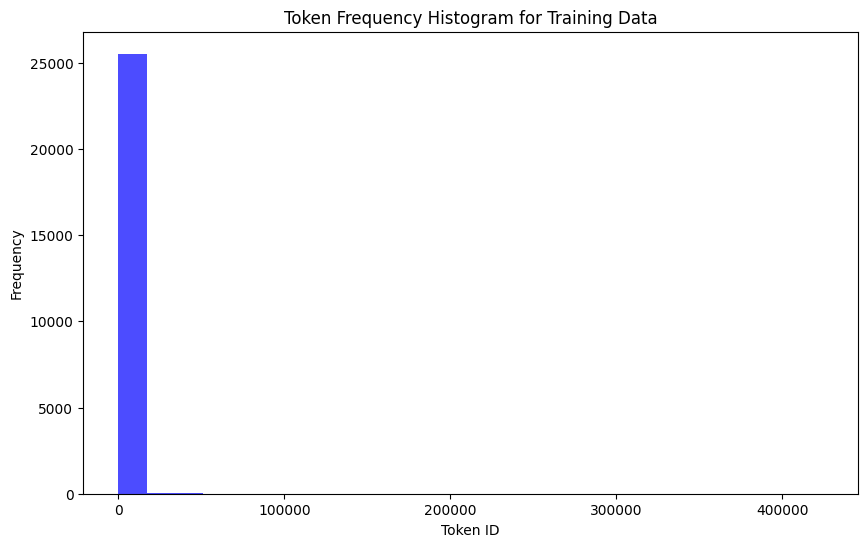

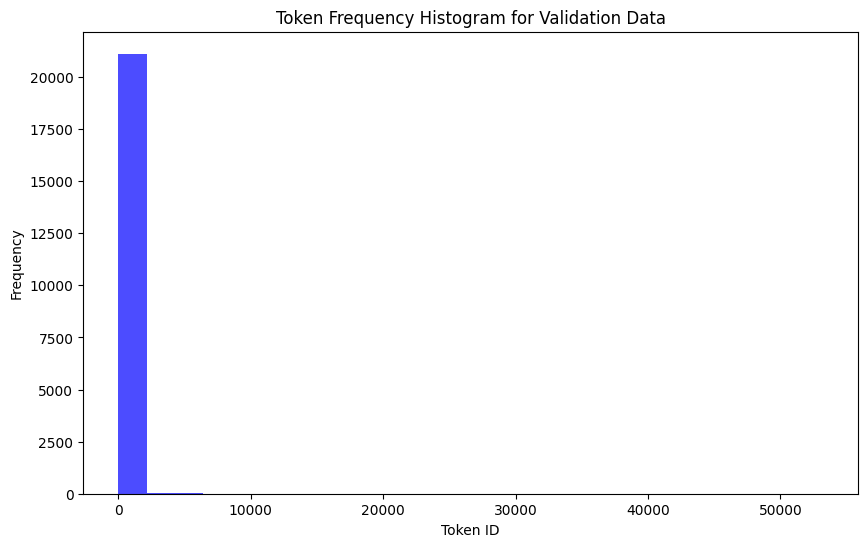

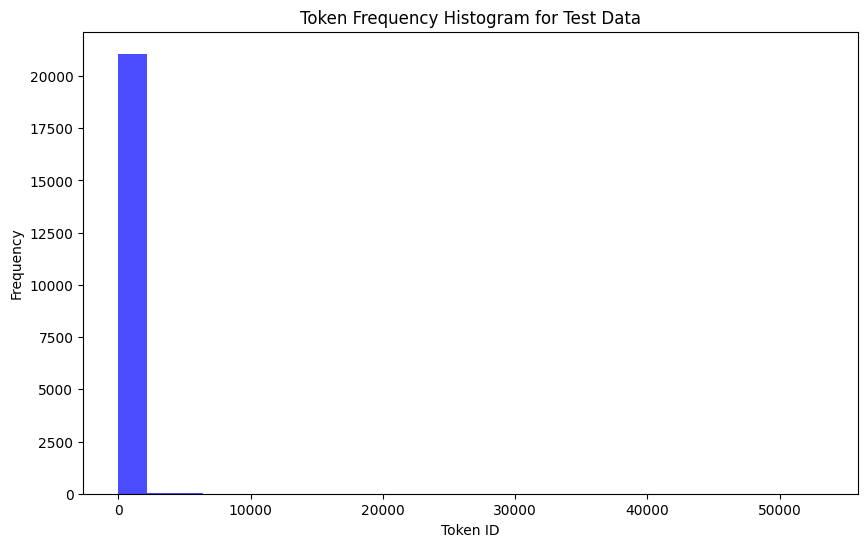

In [ ]:
def plot_histogram(token_freqs, title):
    plt.figure(figsize=(10, 6))
    plt.hist(list(token_freqs.values()), bins=25, color='blue', alpha=0.7)
    plt.title(f'Token Frequency Histogram for {title}')
    plt.xlabel('Token ID')
    plt.ylabel('Frequency')
    plt.show()

plot_histogram(train_token_freqs, 'Training Data')
plot_histogram(valid_token_freqs, 'Validation Data')
plot_histogram(test_token_freqs, 'Test Data')

#Plotting Tokens After Removing [PAD]

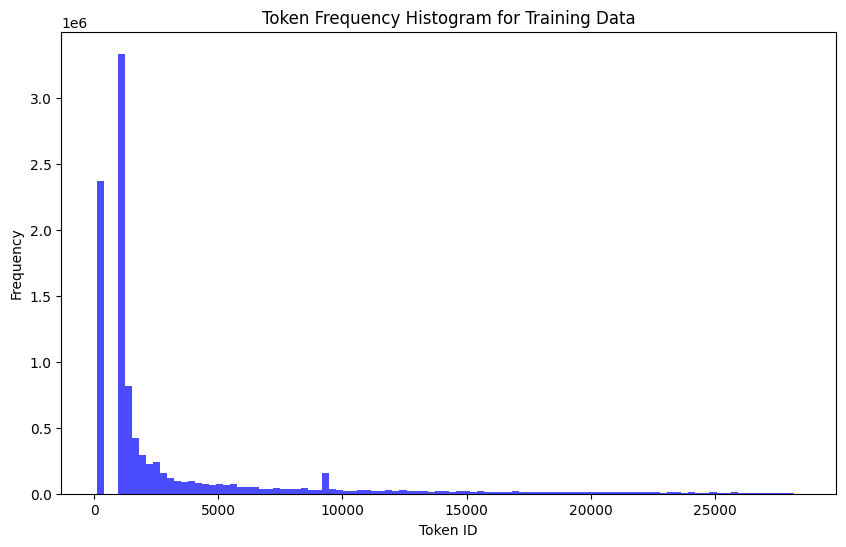

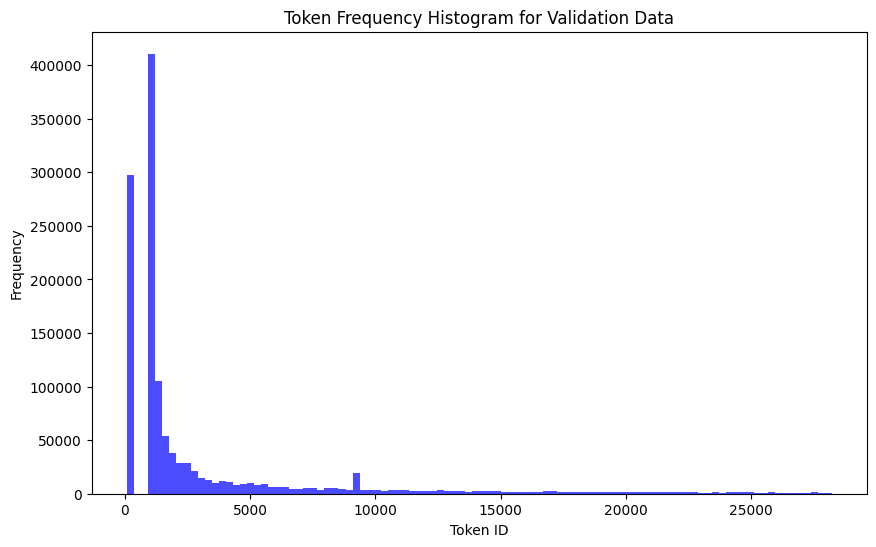

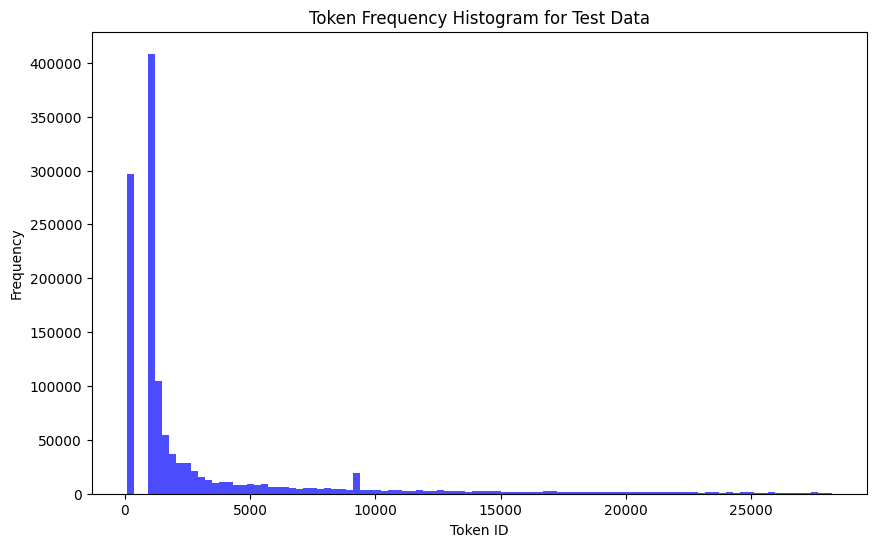

In [ ]:
def plot_histogram(token_freqs, title, remove_pad=True):
    plt.figure(figsize=(10, 6))
    if remove_pad:
        pad_token_id = tokenizer.pad_token_id
        if pad_token_id in token_freqs:
            del token_freqs[pad_token_id]

    token_ids = list(token_freqs.keys())
    frequencies = list(token_freqs.values())


    num_bins = 100

    plt.hist(token_ids, bins=num_bins, weights=frequencies, color='blue', alpha=0.7)
    plt.title(f'Token Frequency Histogram for {title}')
    plt.xlabel('Token ID')
    plt.ylabel('Frequency')
    plt.show()

plot_histogram(train_token_freqs, 'Training Data', remove_pad=True)
plot_histogram(valid_token_freqs, 'Validation Data', remove_pad=True)
plot_histogram(test_token_freqs, 'Test Data', remove_pad=True)

In [ ]:
def find_top_tokens(token_freqs, tokenizer, n=5):
    top_tokens = token_freqs.most_common(n)
    top_tokens = [(tokenizer.decode([token_id]), count) for token_id, count in top_tokens]
    return top_tokens

In [ ]:
top_5_train_tokens = find_top_tokens(train_token_freqs, tokenizer)
print("Top 5 Tokens in Training Data:", top_5_train_tokens)

Top 5 Tokens in Training Data: [('[PAD]', 5717669), ('.', 424392), ('the', 368928), (',', 346136), ('a', 204833)]


[PAD]: This is a special token for padding shorter sentences to a uniform length.It's the most frequent token bc the tokenizer adds this token to every sentence or sequence that is shorter than our specified maximum length (MAX_LEN). The high frequency (5,717,669 occurrences) indicates that a significant portion of the data consists of sequences shorter than the maximum length and need padding. Since pad occurs so frequently, it is hard to visualize the occurance of the other tokens in the dataset. As such I have plotted all the hstograms again without pad to gain a better understanding of the other tokens.

. (Period): Punctuation denoting the end of a sentence. Its high frequency (424,392 occurrences) reflects the prevalence of complete sentences in the dataset.

the: The word "the" is one of the most common words in the english which explains its frequent occurrence (368,928).

, (Comma): Punctuation mark - again its high frequency (346,136) is expected since commas are so common in the english language.

a: Again the word "a" is a frquently used word - (204,833 occurrences in dataset).

### Part (v)


In [ ]:
# TO BE COMPLETED

for batch in train_data_loader:
    single_batch = batch
    break

input_ids = single_batch['input_ids'][0].unsqueeze(0)
attention_mask = single_batch['attention_mask'][0].unsqueeze(0)

# Feed the input through BERT
with torch.no_grad():
    outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)

# hidden states and pooled output
hidden_states = outputs.last_hidden_state
pooled_output = outputs.pooler_output

print("Hidden States Shape:", hidden_states.shape)
print("Pooled Output Shape:", pooled_output.shape)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Hidden States Shape: torch.Size([1, 400, 768])
Pooled Output Shape: torch.Size([1, 768])


1. **Hidden States ([1, 400, 768])**

  The first Dimension (1) represents the batch size. Here it's 1 because we're processing a single sample. This number would correspond to the number of samples in the batch.

  The second Dimension (400) is the sequence length of the input text after tokenization - it represents the number of tokens (including special tokens) in the processed text. We specifiec MAX_LEN to be 400 when we prepared the DataLoader. This means each input sequence is either truncated or padded to have exactly 400 tokens.

  The third Dimension (768) represents the size of the hidden layers in the BERT model. In the case of bert-base-cased, the model has hidden layers of size 768. This is a feature of the model's architechture.

2. **Pooled Output ([1, 768])**

  The first Dimension (1) also represents the batch size.

  The second Dimension (768) represents the pooled embedding size, which is the same as the hidden layer size of the BERT model.

  (The pooled output derived from the hidden state of the [CLS] token (i.e., first token) after passing through additional pooling layers (like a fully connected layer with tanh activation in the original BERT model). This pooled output is often used for classification tasks, bc it provides a fixed-size vector summarizing the entire input sequence)

## Part 2. Model Architecture

### Part (i)

A review classifier model that builds on the pooled output from the Bert model to identify positive and negative reviews.

In [ ]:
class SentimentClassifierPooled(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifierPooled, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    pooled_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)[1]
    dropout_output = self.drop(pooled_output)
    return self.out(dropout_output)

### Part (ii)

The architecture for a review classifier model that uses the last hidden output from the Bert model to identify positive and negative reviews.

In [ ]:
class SentimentClassifierLast(nn.Module):

  def __init__(self, n_classes, embedding_dim=768):
    super(SentimentClassifierLast, self).__init__()
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(embedding_dim, n_classes)

  def forward(self, embeddings):
    dropout_output = self.drop(embeddings)
    return self.out(dropout_output)

## Part 3. Training [3 pt]

### Part (i)

`get_accuracy` function,  will compute the
accuracy (rate) of the model across a dataset (e.g. validation set).

In [ ]:
def get_accuracy(model, data_loader):
    """ Compute the accuracy of the `model` across a dataset `data`

    Example usage:

    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid_loader) # the variable `valid_loader` is from above
    """
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for embeddings, labels in data_loader:
            embeddings, labels = embeddings.to(device), labels.to(device)
            outputs = model(embeddings)
            predictions = torch.argmax(outputs, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    return correct / total

### Part (ii)


*Before training we'll save BERT embeddings so that the training doesn't crash or the session doesn't time out:*

In [ ]:
torch.cuda.empty_cache()

In [ ]:
sentiment_mapping = {"positive": 1, "negative": 0}
y_train = [sentiment_mapping[label] for label in y_train]
y_valid = [sentiment_mapping[label] for label in y_valid]

BATCH_SIZE_FOR_TRAIN = 2
BATCH_SIZE_FOR_VAL = 2

train_data = MovieReviewDataset(X_train, y_train, tokenizer, MAX_LEN)
valid_data = MovieReviewDataset(X_valid, y_valid, tokenizer, MAX_LEN)

train_data_loader = DataLoader(train_data, batch_size=BATCH_SIZE_FOR_TRAIN, shuffle=True, num_workers=4)
valid_data_loader = DataLoader(valid_data, batch_size=BATCH_SIZE_FOR_VAL, num_workers=4)

In [ ]:
import torch
from transformers import BertTokenizer, BertModel
from torch.utils.data import DataLoader
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME).to(device)
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

def process_in_chunks(data_loader, model, chunk_size=50):
    model.eval()
    all_embeddings = []
    all_labels = []

    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            if i % chunk_size == 0 and i > 0:
                torch.cuda.empty_cache()

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['targets']

            last_hidden_state = model(input_ids=input_ids, attention_mask=attention_mask)[0]
            cls_embeddings = last_hidden_state[:, 0]

            all_embeddings.append(cls_embeddings.cpu())  # Move to CPU to save GPU memory
            all_labels.append(labels.cpu())

    return torch.cat(all_embeddings, 0), torch.cat(all_labels, 0)

In [ ]:
# Running in chunks
try:
    train_embeddings, train_labels = process_in_chunks(train_data_loader, bert_model)
    val_embeddings, val_labels = process_in_chunks(valid_data_loader, bert_model)
except RuntimeError as e:
    print("Runtime error:", e)

torch.save((train_embeddings, train_labels), 'train_bert_embeddings.pt')
torch.save((val_embeddings, val_labels), 'val_bert_embeddings.pt')

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

In [ ]:
train_embeddings, train_labels = torch.load('train_bert_embeddings.pt')
val_embeddings, val_labels = torch.load('val_bert_embeddings.pt')

In [ ]:
train_dataset = TensorDataset(train_embeddings, train_labels)
val_dataset = TensorDataset(val_embeddings, val_labels)

In [ ]:
BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

Training:

In [ ]:

from transformers import AdamW, get_linear_schedule_with_warmup
import torch
import matplotlib.pyplot as plt
import torch.nn as nn


def train_model(model, train_loader, valid_loader, num_epochs=3, learning_rate=1e-5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)


    total_steps = len(train_loader) * num_epochs

    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0,
                                                num_training_steps=total_steps)

    losses, train_acc, valid_acc = [], [], []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for embeddings, labels in train_loader:
            embeddings, labels = embeddings.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(embeddings)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

        avg_train_loss = total_loss / len(train_loader)
        losses.append(avg_train_loss)

        model.eval()
        with torch.no_grad():
            train_acc.append(get_accuracy(model, train_loader))
            valid_acc.append(get_accuracy(model, valid_loader))

        model.train()
        print(f"Epoch {epoch+1}/{num_epochs}; Loss {avg_train_loss:.4f}; Train Acc {train_acc[-1]:.4f}; Val Acc {valid_acc[-1]:.4f}")

        torch.cuda.empty_cache()

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(losses, label='Train Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='Train Accuracy')
    plt.plot(valid_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

Training SentimentClassifierLast model
Epoch 1/50; Loss 0.4441; Train Acc 0.8145; Val Acc 0.8048
Epoch 2/50; Loss 0.4422; Train Acc 0.8145; Val Acc 0.8052
Epoch 3/50; Loss 0.4407; Train Acc 0.8144; Val Acc 0.8044
Epoch 4/50; Loss 0.4447; Train Acc 0.8143; Val Acc 0.8064
Epoch 5/50; Loss 0.4440; Train Acc 0.8146; Val Acc 0.8056
Epoch 6/50; Loss 0.4423; Train Acc 0.8147; Val Acc 0.8070
Epoch 7/50; Loss 0.4422; Train Acc 0.8148; Val Acc 0.8072
Epoch 8/50; Loss 0.4419; Train Acc 0.8147; Val Acc 0.8042
Epoch 9/50; Loss 0.4415; Train Acc 0.8147; Val Acc 0.8056
Epoch 10/50; Loss 0.4437; Train Acc 0.8146; Val Acc 0.8060
Epoch 11/50; Loss 0.4426; Train Acc 0.8149; Val Acc 0.8072
Epoch 12/50; Loss 0.4445; Train Acc 0.8150; Val Acc 0.8070
Epoch 13/50; Loss 0.4420; Train Acc 0.8149; Val Acc 0.8060
Epoch 14/50; Loss 0.4416; Train Acc 0.8149; Val Acc 0.8066
Epoch 15/50; Loss 0.4423; Train Acc 0.8151; Val Acc 0.8070
Epoch 16/50; Loss 0.4433; Train Acc 0.8149; Val Acc 0.8072
Epoch 17/50; Loss 0.4439; 

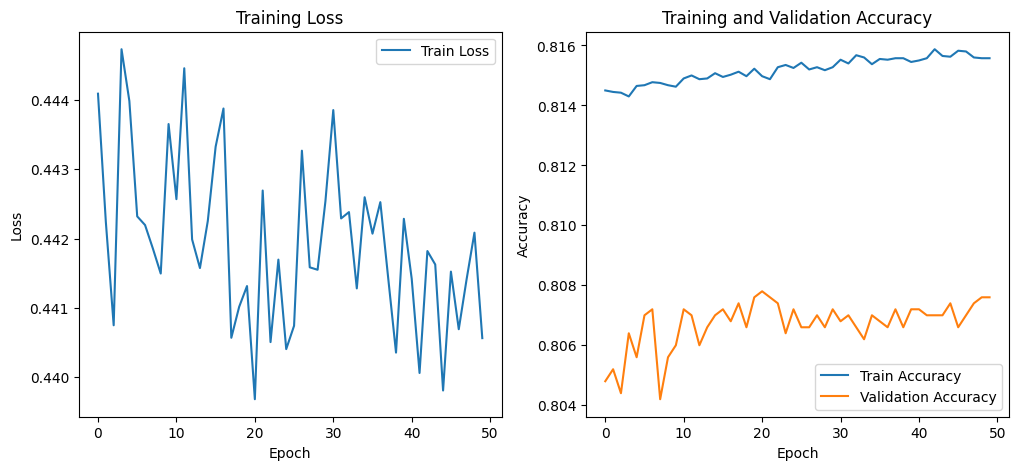

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SentimentClassifierLast(n_classes=2, embedding_dim=768).to(device)
print("Training SentimentClassifierLast model")
train_model(model, train_loader, valid_loader, num_epochs=50, learning_rate=1e-5)

### Part (iii)

4 hyperparameters to tune.

1. **Learning Rate**
    
    This is a crucial hyperparameter to train as it controls the step size at each iteration while moving toward a minimum of the loss function. If set too high, the training might not converge; if too low, training can be slow or get stuck in a local minimum.

    In the previous training, the model is showing steady improvement in accuracy over epochs, but the increments are small. This could indicate that the learning rate might be slightly lower than optimal. We will test by increasing the learning rate to 2e-5. A higher learning rate could help the model to converge faster, we also need to be cautious to not set it too high as it might overshoot the minimum loss.

Training SentimentClassifierLast model
Epoch 1/50; Loss 0.4670; Train Acc 0.7950; Val Acc 0.7872
Epoch 2/50; Loss 0.4654; Train Acc 0.7956; Val Acc 0.7860
Epoch 3/50; Loss 0.4654; Train Acc 0.7970; Val Acc 0.7896
Epoch 4/50; Loss 0.4630; Train Acc 0.7971; Val Acc 0.7886
Epoch 5/50; Loss 0.4636; Train Acc 0.7984; Val Acc 0.7918
Epoch 6/50; Loss 0.4612; Train Acc 0.7990; Val Acc 0.7932
Epoch 7/50; Loss 0.4601; Train Acc 0.7998; Val Acc 0.7944
Epoch 8/50; Loss 0.4588; Train Acc 0.7999; Val Acc 0.7916
Epoch 9/50; Loss 0.4571; Train Acc 0.8007; Val Acc 0.7948
Epoch 10/50; Loss 0.4556; Train Acc 0.8015; Val Acc 0.7952
Epoch 11/50; Loss 0.4583; Train Acc 0.8018; Val Acc 0.7962
Epoch 12/50; Loss 0.4559; Train Acc 0.8023; Val Acc 0.7958
Epoch 13/50; Loss 0.4552; Train Acc 0.8024; Val Acc 0.7958
Epoch 14/50; Loss 0.4555; Train Acc 0.8033; Val Acc 0.7964
Epoch 15/50; Loss 0.4545; Train Acc 0.8040; Val Acc 0.7970
Epoch 16/50; Loss 0.4543; Train Acc 0.8042; Val Acc 0.7972
Epoch 17/50; Loss 0.4545; 

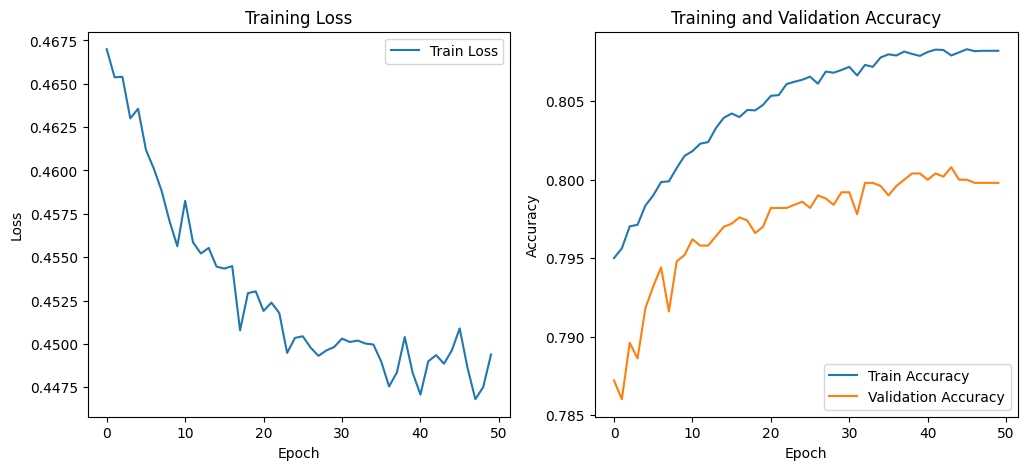

In [ ]:
print("Training SentimentClassifierLast model")
train_model(model, train_loader, valid_loader, num_epochs=50, learning_rate=2e-5)

There was a noticeable improvement in both training and validation accuracies. This suggests that the initial learning rate might have been too conservative, and the model benefited from a slightly more aggressive learning rate.

2. **Number of Epochs**

  Related to the optimizer, but it’s an important hyperparameter to tune since it is also about the number of times the model will see the entire dataset. A higher number of epochs can lead to better training, but also to overfitting. On the other hand too few epochs might mean underfitting.

  In the previous training instances the model's accuracy is gradually increasing even at the 50th epoch, which suggests that it hasn't fully converged yet. We will increase the number of epochs to 70 and watch out for watch out for signs of overfitting, (i.e, the validation accuracy plateauing or decreasing). We will use the learning rate of 2e-5

Training SentimentClassifierLast model
Epoch 1/70; Loss 0.4491; Train Acc 0.8082; Val Acc 0.8008
Epoch 2/70; Loss 0.4477; Train Acc 0.8085; Val Acc 0.8000
Epoch 3/70; Loss 0.4481; Train Acc 0.8088; Val Acc 0.8004
Epoch 4/70; Loss 0.4464; Train Acc 0.8090; Val Acc 0.8008
Epoch 5/70; Loss 0.4462; Train Acc 0.8088; Val Acc 0.8004
Epoch 6/70; Loss 0.4460; Train Acc 0.8095; Val Acc 0.8016
Epoch 7/70; Loss 0.4471; Train Acc 0.8096; Val Acc 0.8012
Epoch 8/70; Loss 0.4460; Train Acc 0.8095; Val Acc 0.8008
Epoch 9/70; Loss 0.4460; Train Acc 0.8098; Val Acc 0.8018
Epoch 10/70; Loss 0.4455; Train Acc 0.8101; Val Acc 0.8022
Epoch 11/70; Loss 0.4470; Train Acc 0.8098; Val Acc 0.8024
Epoch 12/70; Loss 0.4467; Train Acc 0.8105; Val Acc 0.8012
Epoch 13/70; Loss 0.4458; Train Acc 0.8104; Val Acc 0.8028
Epoch 14/70; Loss 0.4463; Train Acc 0.8105; Val Acc 0.8028
Epoch 15/70; Loss 0.4444; Train Acc 0.8107; Val Acc 0.8024
Epoch 16/70; Loss 0.4445; Train Acc 0.8108; Val Acc 0.8030
Epoch 17/70; Loss 0.4435; 

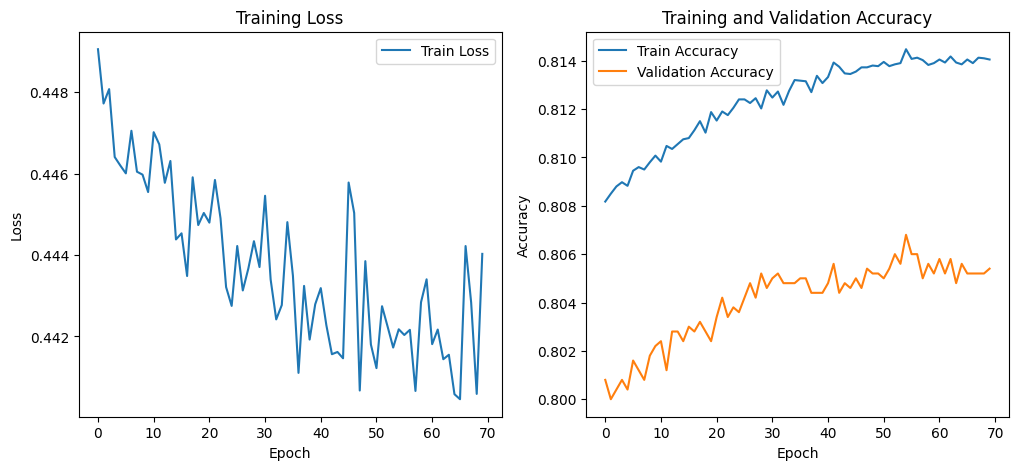

In [ ]:
print("Training SentimentClassifierLast model")
train_model(model, train_loader, valid_loader, num_epochs=70, learning_rate=2e-5)

There is a consistent but gradual improvement in both training and validation accuracy over the extended epochs. This indicates that the model continues to learn and adapt even beyond the initial 50 epochs, however, at a slower pace.Training for such a high number of epochs may not be the most efficient use of resources, especially if similar performance can be achieved with fewer epochs and optimized hyperparameters.

3. **Dropout Rate**

  This is a technique used to prevent overfitting. The dropout rate (p in nn.Dropout(p)) is the probability of an element to be zeroed. Adjusting this can help in reducing overfitting (if the model is too complex) or underfitting (if the model is too simple).

  The dropout rate we've used previously is 0.3. Given that the model is improving consistently and doesn't show signs of overfitting, we will experiment with slightly reducing the dropout rate to 0.25. This allows more information to flow through the network - might be beneficial since there's no current indication of overfitting.

In [ ]:
class LowDropSentimentClassifierLast(nn.Module):

  def __init__(self, n_classes, embedding_dim=768):
    super(LowDropSentimentClassifierLast, self).__init__()
    self.drop = nn.Dropout(p=0.25)
    self.out = nn.Linear(embedding_dim, n_classes)

  def forward(self, embeddings):
    dropout_output = self.drop(embeddings)
    return self.out(dropout_output)

Training SentimentClassifierLast model
Epoch 1/50; Loss 0.6734; Train Acc 0.6991; Val Acc 0.6964
Epoch 2/50; Loss 0.6226; Train Acc 0.7245; Val Acc 0.7188
Epoch 3/50; Loss 0.5908; Train Acc 0.7363; Val Acc 0.7264
Epoch 4/50; Loss 0.5685; Train Acc 0.7440; Val Acc 0.7352
Epoch 5/50; Loss 0.5528; Train Acc 0.7495; Val Acc 0.7440
Epoch 6/50; Loss 0.5407; Train Acc 0.7548; Val Acc 0.7502
Epoch 7/50; Loss 0.5313; Train Acc 0.7597; Val Acc 0.7538
Epoch 8/50; Loss 0.5222; Train Acc 0.7637; Val Acc 0.7588
Epoch 9/50; Loss 0.5165; Train Acc 0.7671; Val Acc 0.7620
Epoch 10/50; Loss 0.5102; Train Acc 0.7700; Val Acc 0.7642
Epoch 11/50; Loss 0.5056; Train Acc 0.7727; Val Acc 0.7634
Epoch 12/50; Loss 0.5004; Train Acc 0.7746; Val Acc 0.7662
Epoch 13/50; Loss 0.4982; Train Acc 0.7756; Val Acc 0.7698
Epoch 14/50; Loss 0.4943; Train Acc 0.7778; Val Acc 0.7676
Epoch 15/50; Loss 0.4919; Train Acc 0.7797; Val Acc 0.7704
Epoch 16/50; Loss 0.4896; Train Acc 0.7805; Val Acc 0.7702
Epoch 17/50; Loss 0.4868; 

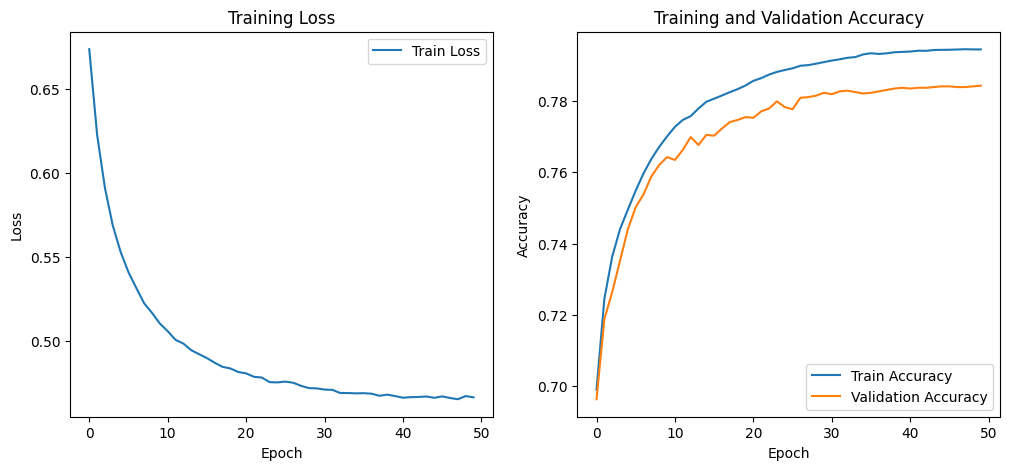

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LowDropSentimentClassifierLast(n_classes=2, embedding_dim=768).to(device)
print("Training SentimentClassifierLast model")
train_model(model, train_loader, valid_loader, num_epochs=50, learning_rate=1e-5)

The lower dropout rate seems to allow the model to fit the training data slightly better, as indicated by the gradual but consistent improvement in training accuracy. However, it does not lead to overfitting, as the validation accuracy also improves.

4. **Batch Size**

  The number of samples processed before the model is updated. A larger batch size provides a more accurate estimate of the gradient, but requires more memory and can make training slower. A smaller batch size can speed up training but might lead to more noise in the gradient estimation. Previously our batch size was set to 16. HEre we will try a batch size of 32. We will continue to use the lower dropout of 0.25.

In [ ]:
BATCH_SIZE = 32
new_train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
new_valid_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

Training SentimentClassifierLast model
Epoch 1/50; Loss 0.6718; Train Acc 0.7002; Val Acc 0.7054
Epoch 2/50; Loss 0.6351; Train Acc 0.7165; Val Acc 0.7192
Epoch 3/50; Loss 0.6120; Train Acc 0.7264; Val Acc 0.7276
Epoch 4/50; Loss 0.5915; Train Acc 0.7336; Val Acc 0.7314
Epoch 5/50; Loss 0.5781; Train Acc 0.7391; Val Acc 0.7346
Epoch 6/50; Loss 0.5645; Train Acc 0.7446; Val Acc 0.7372
Epoch 7/50; Loss 0.5550; Train Acc 0.7490; Val Acc 0.7428
Epoch 8/50; Loss 0.5453; Train Acc 0.7528; Val Acc 0.7442
Epoch 9/50; Loss 0.5387; Train Acc 0.7569; Val Acc 0.7494
Epoch 10/50; Loss 0.5330; Train Acc 0.7609; Val Acc 0.7510
Epoch 11/50; Loss 0.5266; Train Acc 0.7634; Val Acc 0.7564
Epoch 12/50; Loss 0.5219; Train Acc 0.7660; Val Acc 0.7580
Epoch 13/50; Loss 0.5174; Train Acc 0.7681; Val Acc 0.7602
Epoch 14/50; Loss 0.5148; Train Acc 0.7705; Val Acc 0.7614
Epoch 15/50; Loss 0.5102; Train Acc 0.7717; Val Acc 0.7660
Epoch 16/50; Loss 0.5077; Train Acc 0.7736; Val Acc 0.7666
Epoch 17/50; Loss 0.5051; 

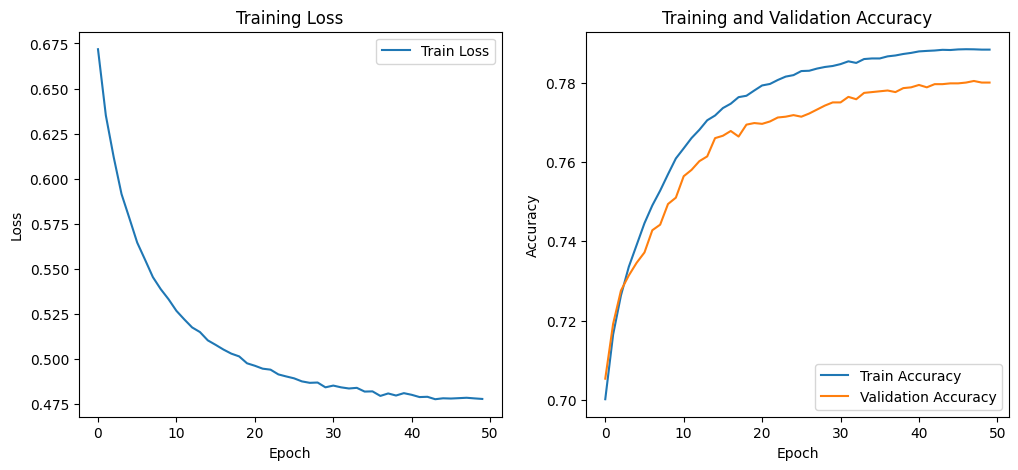

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LowDropSentimentClassifierLast(n_classes=2, embedding_dim=768).to(device)
print("Training SentimentClassifierLast model")
train_model(model, new_train_loader, new_valid_loader, num_epochs=50, learning_rate=1e-5)

Larger batch sizes can sometimes lead to poorer generalization. However, in this case, the final validation accuracy doesn't show a significant drop compared to training with smaller batch sizes, indicating that the model still generalizes well.

Below we will train a model with the folowing hyperparameters:
* Learning Rate: 2e-5
* Number of Epochs: 70
* Dropout Rate: 0.25
* Batch Size: 32

Training SentimentClassifierLast model
Epoch 1/70; Loss 0.6472; Train Acc 0.7292; Val Acc 0.7280
Epoch 2/70; Loss 0.5948; Train Acc 0.7413; Val Acc 0.7370
Epoch 3/70; Loss 0.5642; Train Acc 0.7510; Val Acc 0.7448
Epoch 4/70; Loss 0.5441; Train Acc 0.7582; Val Acc 0.7512
Epoch 5/70; Loss 0.5289; Train Acc 0.7651; Val Acc 0.7574
Epoch 6/70; Loss 0.5177; Train Acc 0.7705; Val Acc 0.7622
Epoch 7/70; Loss 0.5092; Train Acc 0.7751; Val Acc 0.7664
Epoch 8/70; Loss 0.5012; Train Acc 0.7776; Val Acc 0.7670
Epoch 9/70; Loss 0.4964; Train Acc 0.7801; Val Acc 0.7722
Epoch 10/70; Loss 0.4908; Train Acc 0.7820; Val Acc 0.7726
Epoch 11/70; Loss 0.4876; Train Acc 0.7839; Val Acc 0.7766
Epoch 12/70; Loss 0.4847; Train Acc 0.7860; Val Acc 0.7772
Epoch 13/70; Loss 0.4815; Train Acc 0.7879; Val Acc 0.7770
Epoch 14/70; Loss 0.4781; Train Acc 0.7892; Val Acc 0.7806
Epoch 15/70; Loss 0.4750; Train Acc 0.7896; Val Acc 0.7808
Epoch 16/70; Loss 0.4737; Train Acc 0.7913; Val Acc 0.7822
Epoch 17/70; Loss 0.4715; 

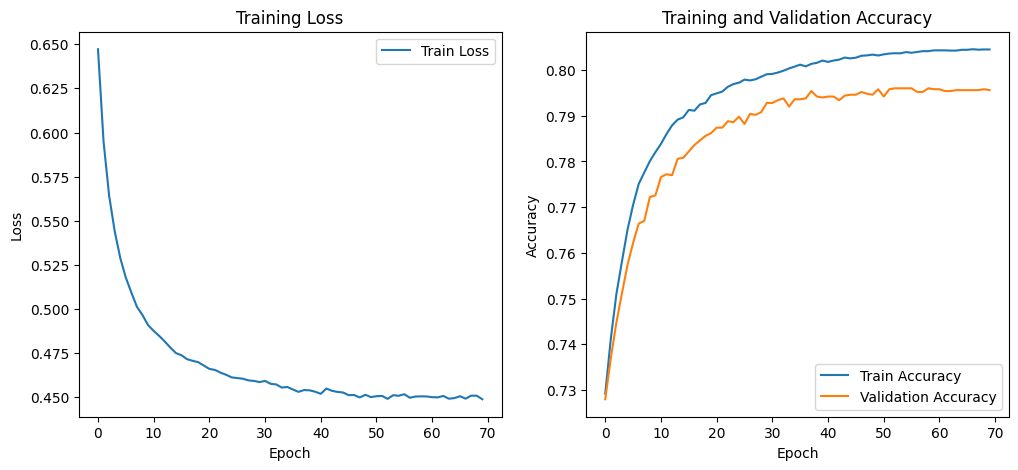

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_b_model = LowDropSentimentClassifierLast(n_classes=2, embedding_dim=768).to(device)
print("Training SentimentClassifierLast model")
train_model(best_b_model, new_train_loader, new_valid_loader, num_epochs=70, learning_rate=2e-5)

## Part 4. Evaluation

### Part (i)



In [ ]:
def evaluate_bert_model_and_collect_misclassified(model, data_loader, original_data):
    """ Evaluates BERT model and collects misclassified examples from the test set """
    model.eval()
    correct, total = 0, 0
    misclassified = []

    with torch.no_grad():
        for batch in data_loader:
            embeddings = batch[0].to(device)  # Assuming the first element of the batch is embeddings
            labels = batch[1].to(device)  # Assuming the second element of the batch is labels
            outputs = model(embeddings)
            predictions = torch.argmax(outputs, dim=1)

            correct += (predictions == labels).sum().item()
            total += labels.size(0)

            mismatches = predictions != labels
            if mismatches.any():
                mismatches_indices = mismatches.nonzero(as_tuple=False).squeeze()
                # Handle the case where there is only one mismatched index
                if mismatches_indices.dim() == 0:
                    mismatches_indices = mismatches_indices.unsqueeze(0)
                for idx in mismatches_indices:
                    original_idx = idx.item()
                    misclassified_review = original_data[original_idx]
                    true_label = labels[idx].item()
                    predicted_label = predictions[idx].item()
                    misclassified.append((misclassified_review, true_label, predicted_label))

    accuracy = correct / total
    return accuracy, misclassified

In [ ]:
try:
    test_embeddings, test_labels = process_in_chunks(test_data_loader, bert_model)
except RuntimeError as e:
    print("Runtime error:", e)

torch.save((test_embeddings, test_labels), 'test_bert_embeddings.pt')

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

In [ ]:
torch.save((test_embeddings, test_labels), 'test_bert_embeddings.pt')

In [ ]:
test_embeddings, test_labels = torch.load('test_bert_embeddings.pt')
test_dataset = TensorDataset(test_embeddings, test_labels)
test_data_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=4)

In [ ]:
test_accuracy, misclassified_examples = evaluate_bert_model_and_collect_misclassified(best_b_model, test_data_loader, df_test['review'].tolist())
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 0.8026


In [ ]:
import pandas as pd

lstm_train_acc = 0.8990
lstm_val_acc = 0.8376
lstm_test_acc = 0.8410

bert_train_acc = 0.8051
bert_val_acc = 0.7962
bert_test_acc = 0.8020

accuracy_summary = pd.DataFrame({
    'Model': ['LSTM', 'BERT'],
    'Training Accuracy': [lstm_train_acc, bert_train_acc],
    'Validation Accuracy': [lstm_val_acc, bert_val_acc],
    'Test Accuracy': [lstm_test_acc, bert_test_acc]
})

accuracy_summary

,Model,Training Accuracy,Validation Accuracy,Test Accuracy
0,LSTM,0.8990,0.8376,0.841
1,BERT,0.8051,0.7962,0.802


**ANSWER:**
The LSTM model shows a higher training accuracy compared to the BERT model. This could indicate that the LSTM model, with its architecture and hyperparameters, was better able to fit the training data.The LSTM model also outperforms the BERT model on the validation set. This suggests that the LSTM model generalizes better to unseen data compared to the BERT model.
The trend continues with the test accuracy, where the LSTM model demonstrates higher accuracy. This further supports the notion that the LSTM model has better generalization capabilities for this particular problem.

Typically, BERT is known for its strong performance on a wide range of NLP tasks, especially those involving understanding the context and nuances of language. Bert's lower test accuracy is not expected however, as we saw above tuning and model architechture could make a big difference. Perhaps with further tuning, the bERT accuracy may surpass that of the LSTM only model.

### Part (ii)

Report the false positive rate and false negative rate of your model across the test set. Then summarize in a pandas dataframe the false postive and false negative rate of your model obtained on the training, validation, and test data of your best models from Part A and B.

How does the BERT model compare to the approach in part A using only LSTM? Are the results what you expected? Explain.

  **Gathering FPs and FNs from Parts A:**

In [ ]:
# TO BE COMPLETED

import pandas as pd

def calculate_fpr_fnr(misclassified, total_negatives, total_positives):
    fp = sum([1 for _, true, pred in misclassified if true == 0 and pred == 1])
    fn = sum([1 for _, true, pred in misclassified if true == 1 and pred == 0])
    fpr = fp / total_negatives if total_negatives else 0
    fnr = fn / total_positives if total_positives else 0
    return fpr, fnr

In [ ]:
# Evaluating and collecting misclassified examples on all datasets
_, misclassified_train = evaluate_model_and_collect_misclassified(model_best, train_loader, X_train)
_, misclassified_valid = evaluate_model_and_collect_misclassified(model_best, valid_loader, X_valid)

# Total negatives and positives
total_negatives_train, total_positives_train = y_train_tensor.eq(0).sum().item(), y_train_tensor.eq(1).sum().item()
total_negatives_valid, total_positives_valid = y_valid_tensor.eq(0).sum().item(), y_valid_tensor.eq(1).sum().item()
total_negatives_test, total_positives_test = y_test_tensor.eq(0).sum().item(), y_test_tensor.eq(1).sum().item()

# FPR and FNR
fpr_train, fnr_train = calculate_fpr_fnr(misclassified_train, total_negatives_train, total_positives_train)
fpr_valid, fnr_valid = calculate_fpr_fnr(misclassified_valid, total_negatives_valid, total_positives_valid)
fpr_test, fnr_test = calculate_fpr_fnr(misclassified_examples, total_negatives_test, total_positives_test)

data = {
    'Dataset': ['Training', 'Validation', 'Test'],
    'False Positive Rate': [fpr_train, fpr_valid, fpr_test],
    'False Negative Rate': [fnr_train, fnr_valid, fnr_test]
}

df_rates = pd.DataFrame(data)
print(df_rates)

In [ ]:
df_rates.insert(0, 'Model', 'LSTM')

**Gathering FPs and FNs for Part B:**

In [ ]:
train_embeddings, train_labels = torch.load('train_bert_embeddings.pt')
train_dataset = TensorDataset(train_embeddings, train_labels)
train_data_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=4)

valid_embeddings, valid_labels = torch.load('val_bert_embeddings.pt')
valid_dataset = TensorDataset(valid_embeddings, valid_labels)
valid_data_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, num_workers=4)

In [ ]:
import pandas as pd
_, misclassified_train = evaluate_bert_model_and_collect_misclassified(best_b_model, train_data_loader, df_train['review'].tolist())
_, misclassified_valid = evaluate_bert_model_and_collect_misclassified(best_b_model, valid_data_loader, df_valid['review'].tolist())
_, misclassified_test = evaluate_bert_model_and_collect_misclassified(best_b_model, test_data_loader, df_test['review'].tolist())

total_negatives_train = (df_train['sentiment'] == 0).sum()
total_positives_train = (df_train['sentiment'] == 1).sum()

total_negatives_valid = (df_valid['sentiment'] == 0).sum()
total_positives_valid = (df_valid['sentiment'] == 1).sum()

total_negatives_test = (df_test['sentiment'] == 0).sum()
total_positives_test = (df_test['sentiment'] == 1).sum()

fpr_train = len([ex for ex in misclassified_train if ex[1] == 0 and ex[2] == 1]) / total_negatives_train
fnr_train = len([ex for ex in misclassified_train if ex[1] == 1 and ex[2] == 0]) / total_positives_train

fpr_valid = len([ex for ex in misclassified_valid if ex[1] == 0 and ex[2] == 1]) / total_negatives_valid
fnr_valid = len([ex for ex in misclassified_valid if ex[1] == 1 and ex[2] == 0]) / total_positives_valid

fpr_test = len([ex for ex in misclassified_test if ex[1] == 0 and ex[2] == 1]) / total_negatives_test
fnr_test = len([ex for ex in misclassified_test if ex[1] == 1 and ex[2] == 0]) / total_positives_test

rates_df = pd.DataFrame({
    'Dataset': ['Training', 'Validation', 'Test'],
    'False Positive Rate': [fpr_train, fpr_valid, fpr_test],
    'False Negative Rate': [fnr_train, fnr_valid, fnr_test]
})
rates_df.insert(0, 'Model', 'BERT')
print(rates_df)

  Model     Dataset  False Positive Rate  False Negative Rate
0  BERT    Training             0.180947             0.210110
1  BERT  Validation             0.182473             0.226309
2  BERT        Test             0.174249             0.219858


In [ ]:
df_combined = pd.concat([df_rates, b_df_rates], ignore_index=True)

### Part (iii) [3pt DISCUSSION]
Examine some of the misclassified reviews from you best BERT and LSTM models to better identify the differences in the models. Try to provide some justification for any differences in the misclassifications observed in the models.

Is there any part of the review that you could modify to make the classifications correct? Try to make small changes to the review to see if you can make the model make the correct classification while keeping the review as close to the original as possible.

**Part A**

In [ ]:
A_top_5_Misclassified_pos_and_neg = pd.concat([positive_df, negative_df])

NameError: ignored

**Part B**

In [ ]:
def label_to_sentiment(label):
    return "positive" if label == 1 else "negative"

# Apply the function to convert labels in the misclassified data
misclassified_positives = [(rev, label_to_sentiment(true), label_to_sentiment(pred)) for rev, true, pred in misclassified_test if true == 1 and pred == 0]
misclassified_negatives = [(rev, label_to_sentiment(true), label_to_sentiment(pred)) for rev, true, pred in misclassified_test if true == 0 and pred == 1]

# Create DataFrames
df_misclassified_positives = pd.DataFrame(misclassified_positives, columns=['Review', 'True Label', 'Predicted Label'])
df_misclassified_negatives = pd.DataFrame(misclassified_negatives, columns=['Review', 'True Label', 'Predicted Label'])

# Get top 5 misclassified examples from each category
df_top_misclassified_positives = df_misclassified_positives.head(5)
df_top_misclassified_negatives = df_misclassified_negatives.head(5)

# Combine the DataFrames
B_df_top_misclassified = pd.concat([df_top_misclassified_positives, df_top_misclassified_negatives])

# Display the DataFrame
pd.set_option('display.max_colwidth', None)
B_df_top_misclassified

,Review,True Label,Predicted Label
0,"Star Trek Hidden Frontier will surprise you in many ways. First, it's a fan made series, available only on the web, and it features mainly friends & neighbors who have the computer programs and home video cameras and sewing machines to, as Mickey & Judy once put it, put on a show. It's definitely friends & neighbors to, you can tell. A lot of these people aren't the most beautiful looking folks you've ever seen, or the youngest, or the thinnest some of them stumble through their lines like they're walking on marbles some of them have thick accents, or simply don't seem to speak well in the first place, whick makes it virtually impossible to understand a single solitary word that they're saying. Still, you have to admit, for everything these friends & neighbors have put together, it's actually fun to watch. Yes, some of the dialogue is hokey. Yes, it's a little odd (though admittedly a little cool too) watching two Starfleet males kiss (although some of the kissing scenes seem to go on and on.) Yes, you cringe a bit when they clearly quote from ST:TOS, TNG, other shows and the movies, or when you hear the theme from Galaxy Quest played at the beginning and end of every show. Okay. We can get by that. Why? The graphics are first rate. Better than almost anything you've seen. And sometimes, a show or two really stands out story-wise some of them are actually real tear-jerkers.<br /><br />Hidden Frontier is a total guilty pleasure in every sense of the word but you have to give the people involved credit where credit is due. It takes a lot of effort to put on a production of this magnitude. People, sets, costumes, graphics it's a huge effort on a lot of people's parts. We watch, we return, and we thank them.",positive,negative
1,"I expected a good movie. What I got was an even better movie. The chemistry between James and Smith is just incredible. Glad to see him in a major motion picture for once!<br /><br />The movie works, because the actors play their parts perfectly. Will Smith is fantastic with his never ending charm; Kevin James is hilarious, and Eva Mendes...well, let's just say she plays that bitch/sweet/annoying role to the best of her ability.<br /><br />What I loved about the movie was the fact that Will Smith didn't even have to try to be lovable. He just was!! The ""date doctor"" had all the right moves, said everything in the most perfect of ways, and never ever went over the top.<br /><br />The funny parts are hilarious...and the cute, romantic parts are unforgettable.<br /><br />I totally recommend this movie. And no, it is not a chick flick.",positive,negative
2,"If you have any kind of heart and compassion for people, this is a tough movie to watch, at least in the second half of it. <br /><br />It's in that segment where we see nice little kid get beaten up and then a retarded (mentally- challenged) man go off the deep end after he witnesses this brutal act against the child. It's not pleasant material.<br /><br />However, it's a good movie and the acting is good, too. The story will sit with you awhile.<br /><br />""Dominick"" is the mentally-disabled guy and is played by Tom Hulce. I think this might be Hulce's best role ever. He's looked after by a med student, ""Eugene,"" played by Ray Liotta, who became a star the following year with Kevin Costner's ""Field Of Dreams.""<br /><br />Dominick is a goodhearted garbage man who reads ""Hulk"" comic books and loves wrestling. He's the type of ""slow"" guy that you can't help but love and root for to live a happy life. When he freaks out, it's for several good reasons and...well, see the film for the whole story. It's worth your time but be prepared to go on real emotional roller coaster and possibly be very upset at some things you see.",positive,negative
3,"Being a great fan of horror, especially Asian horror, I have seen tons of movies, but this one is outstanding. Why? It does have a plot (which is unfortunately quite rare

### Part (iv) [2pt DISCUSSION]
Find 5 samples of positive and negative reviews on IMDB that were posted recently and evaluate them with your best BERT and LSTM models from parts A and B. How well do they perform?

In [ ]:
rev_a = """Wow!!! I have been looking forward to this since the book came out,
hoping it would be turned into a movie! They truly knew what to keep in the movie,
what to adapt and what to leave in the book. Absolutely fantastic! I'm so happy and
I loved every second of it. The actors did an amazing portrayal of the characters
 and the movie had great pacing and flow. As soon as it finished I would have
  happily stayed in my seat for a second viewing. You could watch this as a
  standalone but you do get more out of it if you have seen the other movies.
  You can see all the ground work and you get insight into many characters as
  well as the creation of the system and how it grew to be what we see in The
  Hunger Games."""

rev_b = """ Style over substance, as one of the reviewers pointed out, nails it.
 Besides being rather boring and predictable, this movie does not entice any
 emotions. For me, feeling for a movie character is very important, but in this
  flick I did not have an empathy for anyone. The story itself and the characters
   in this movie are so cold, you should wear a jumper watching it. Some of the
    main reasons for making a movie: (i) creating a piece of art (comes from the
     heart of the director, e.g. Blade runner by Scott); (ii) making money by
      pushing right buttons in viewers' cognitive response panel (e.g. A. I. By
      Spielberg). Why was this movie made by Fincher is a mystery to me. You will
       miss nothing by not watching it. """

rev_c = """I may consider myself lucky to be alive to watch Christopher Nolan
Works which get better by years. Oppenheimer is - with no doubt- going to be one
of the best movies in the history. Amazing cinematography, Exceptional acting and
terrifying Soundtracks. All the cast are great from cilian Murphy who is going
for the oscar with this role to Rupert Downey jr and Emily blunt and finally rami
malik who has small scenes but you will never forget them. I didn't watch it in
Imax as i couldn't wait and ran to the nearest cinema but now i will sure book an
imax ticket. Don't waste any time, book your ticket and Go watch it.. NOW. """

rev_d = """I'm still collecting my thoughts after experiencing this film, Cillian
Murphy might as well start clearing a space on his mantle for the Best Actor Oscar.
 This film is a masterclass in weaving narratives and different time periods
 while exploring the profound depths of a man whose actions altered the world's
 trajectory forever, for better or worse. Nolan brings us into the complexities
  of Oppenheimer, and all the moral conflicts stirring within him.Murphy's portrayal
   is so riveting that the long run-time became an afterthought. Robert Downey Jr
    also offers a great performance and Nolan's push and pull with how he uses
    sound design throughout is the cherry on top. Some viewers might need a brief
    refresher on WWII and Cold War history, but any film lover should be happy to
    willingly lose themselves in this film for hours on end. """

rev_e = """ As much as it pains me to give a movie called "Barbie" a 10 out of 10,
 I have to do so. It is so brilliantly handled and finely crafted, I have to give
  the filmakers credit. Yes, I am somewhat conservative person and former law
   enforcement officer. I'm a guy. I like guy things. Hell I even enjoyed the
   Battleship movie a few years ago (an absolutely ridiculous but fun romp of an
    action film). But I also like to experience other perspectives. And man oh
    man does this movie deliver that in spades - pretty much encapsulated
    everything my wife has tried to convey about her entire career and life
    experience wrapped up into two hours! The humor, the sets, the acting, and
    the ability to weave the current narrative into the story was just perfect.
    I don't agree with some of the points of the movie, but again, that's ok.
    This movie wasn't designed to give a balanced perspective of men versus women;
     it is a no-holds-barred unapologetic crazy ride of a rant about the real
     issues that women have faced since they were "allowed" to have "real jobs"
     and do the same things as men. Give me a well done film that is a blast to
     watch, that makes you think, and that was done from a place of creativity,
     passion, and attention to detail, and I'll call it what it is: a 10 out of
     10 masterpiece. """

rev_f = """The MCU has absolutely overstayed its welcome. Post Avengers Endgame,
  these projects have been feeling more and more like content than cinema (except
  the rare surprises like GOTG 3). Superhero fatigue, they call it and this movie
  does practically nothing but to amp it up to 11. You watch the trailer, you
  know what happens. You bet on originality, you end up homeless. There's nothing
  new for me to say that I haven't already said about any of the other MCU
  content as of late. It's so generic that I'm confident a year from now, no one
  would remember this movie even existed. With every new MCU project, the
  jokes-per-minute ratio keeps getting worse, the villains are a writer's version
  of a stock photograph (I can't even remember the villain's name in this
  movie and it hasn't even been a day since I watched it), the CGI is so out
  there you can almost see the CGI artists' tears on screen, and it's getting
  more and more difficult to tell each MCU project apart cos they're all
  just the same. The only few positives I can identify here are actresse
  Iman Vellani and Brie Larson (Larson, who seems much more relaxed and settled
  into her superhero boots), and maybe the flashy action sequences. Otherwise,
  there's nothing here to watch, nothing here to experience and nothing here to
  enjoy. What a shame. """

rev_g = """Marvel movies really have fallen apart haven't they? This is definitely
  one of the worst Marvels movie I have seen out of all the Marvel movies I had
  watched. There really isn't too much to say about the movie because "The Marvels"
  is pretty much like almost every single Marvel movie but the writing, humor,
  direction, and performances are pretty much all over the place. Director Nia
  DaCosta has made "Little Woods" which I liked but her direction here is pretty
  bad and goes all over the place. The special effects are kind of rough on the
  edges, the actions and thrills were just okay and the performances, despite a
  pretty good cast, they aren't very good. Brie Larson is an actress I like but
  unfortunately her performance felt weak and lacking. The other performances as
  well including the child performances. The story isn't interesting as the
  writing is pretty bland and none of the characters were interesting. With a
  short runtime, the movie surprisingly was really boring. I do like superhero
  movies but it seems this one really just sucked. Overall, it's bad.  """

rev_h = """Gareth Edwards proves himself to be an astoundingly brilliant director
  with The Creator, as he crafts a visual and auditory world rich with layers of detail,
  and characters that we quickly understand and naturally grow over the course of the story.
  He made an $80 million movie that looks like it cost at least twice that. This cost
  less than half of what Thor: Love and Thunder cost. Let that sink in.
  Edwards shows he's a better director than writer, as the film is far from original,
  borrowing concepts and themes from plenty of old classic sci-fi stories. And it's
  also burdened with some clunky dialogue and rushed, convenient crucial plot points.
  Yeah, it's imperfect. But it's made with a confidence and care that goes
  beyond the degree of admirable. It's an earnest expression of love, redemption,
  sacrifice, and forgiveness put out by a filmmaker who really cares for the
  characters whose story he's telling.
  It's a work of art that, even with its flaws, deserves to be seen. """

rev_i = """We went to see this in IMAX and really wanted to enjoy it but it felt
 flat for us. The story is bad. The dialogues are bad. People commenting that the
 dialogues are so bad that they seem written by an AI are absolutely right.
 It´s predictable. You don´t feel for the characters, any of them. The special
 effects didn´t seem like something new either. It´s very formulaic. Like written
 for children. I don´t even think that teenagers will enjoy it. It would have to
 be younger than preteens and I wouldn´t recommend it even then. There is no
 story to tell. I´m sorry we went to the cinema to see this, it wasn´t worth it."""

rev_j = """I'm surprised by all the positive reviews here. If you like movies
that are stylistic and pretty in theory, but boring and consulates in practice,
I guess you'll like this movie. But if you're someone who actually cares about
plot, I'd definitely pass.
For starters, this movie takes forever to get to the point. It starts off with
narration that just continues and continues. If you make it past the dull start,
you'll discover an unoriginal plot that's just not interesting enough to justify
its unnecessary complexity. There are a few stand out moments, but they're strung
together poorly. There's also nothing to get you invested in the characters or
their well-being. You're just watching a guy do stuff, and sometimes it's
interesting, but a lot of the times it's not."""

In [ ]:
reviews = [
    rev_a, rev_b, rev_c, rev_d, rev_e,
    rev_f, rev_g, rev_h, rev_i, rev_j
]
sentiments = [
    "Positive", "Negative", "Positive", "Positive", "Positive",
    "Negative", "Negative", "Positive", "Negative", "Negative"
]
baby_data = {'Review': reviews, 'Sentiment': sentiments}
baby_df = pd.DataFrame(baby_data)

**1. LSTM Only**

In [ ]:
# TO BE COMPLETED
baby_X = baby_df['Review'].values
baby_y = baby_df['Sentiment'].values

In [ ]:
# Just checking if all reviews are there
pd.set_option('display.max_colwidth', None)
baby_df

,Review,Sentiment
0,"Wow!!! I have been looking forward to this since the book came out, \nhoping it would be turned into a movie! They truly knew what to keep in the movie, \nwhat to adapt and what to leave in the book. Absolutely fantastic! I'm so happy and \nI loved every second of it. The actors did an amazing portrayal of the characters\n and the movie had great pacing and flow. As soon as it finished I would have\n happily stayed in my seat for a second viewing. You could watch this as a \n standalone but you do get more out of it if you have seen the other movies. \n You can see all the ground work and you get insight into many characters as \n well as the creation of the system and how it grew to be what we see in The \n Hunger Games.",Positive
1,"Style over substance, as one of the reviewers pointed out, nails it.\n Besides being rather boring and predictable, this movie does not entice any \n emotions. For me, feeling for a movie character is very important, but in this\n flick I did not have an empathy for anyone. The story itself and the characters\n in this movie are so cold, you should wear a jumper watching it. Some of the\n main reasons for making a movie: (i) creating a piece of art (comes from the\n heart of the director, e.g. Blade runner by Scott); (ii) making money by\n pushing right buttons in viewers' cognitive response panel (e.g. A. I. By \n Spielberg). Why was this movie made by Fincher is a mystery to me. You will\n miss nothing by not watching it.",Negative
2,"I may consider myself lucky to be alive to watch Christopher Nolan \nWorks which get better by years. Oppenheimer is - with no doubt- going to be one \nof the best movies in the history. Amazing cinematography, Exceptional acting and \nterrifying Soundtracks. All the cast are great from cilian Murphy who is going \nfor the oscar with this role to Rupert Downey jr and Emily blunt and finally rami \nmalik who has small scenes but you will never forget them. I didn't watch it in \nImax as i couldn't wait and ran to the nearest cinema but now i will sure book an \nimax ticket. Don't waste any time, book your ticket and Go watch it.. NOW.",Positive
3,"I'm still collecting my thoughts after experiencing this film, Cillian \nMurphy might as well start clearing a space on his mantle for the Best Actor Oscar.\n This film is a masterclass in weaving narratives and different time periods \n while exploring the profound depths of a man whose actions altered the world's \n trajectory forever, for better or worse. Nolan brings us into the complexities\n of Oppenheimer, and all the moral conflicts stirring within him.Murphy's portrayal\n is so riveting that the long run-time became an afterthought. Robert Downey Jr\n also offers a great performance and Nolan's push and pull with how he uses \n sound design throughout is the cherry on top. Some viewers might need a brief\n refresher on WWII and Cold War history, but any film lover should be happy to \n willingly lose themselves in this film for hours on end.",Positive
4,"As much as it pains me to give a movie called ""Barbie"" a 10 out of 10,\n I have to do so. It is so brilliantly handled and finely crafted, I have to give\n the filmakers credit. Yes, I am somewhat conservative person and former law\n enforcement officer. I'm a guy. I like guy things. Hell I even enjoyed the \n Battleship movie a few years ago (an absolutely ridiculous but fun romp of an\n action film). But I also like to experience other perspectives. And man oh \n man does this movie deliver that in spades - pretty much encapsulated \n everything my wife has tried to convey about her entire career and life \n experience wrapped up into two hours! The humor, the sets, the acting, and \n the ability to weave the current narrative into the story was just perfect. \n I don't agree with some of the points of the movie, but again, that's ok. \n This movie wasn't designed to give a balanced perspective of men versus women;\n it is a no-holds-barr

In [ ]:
baby_X_test_encoded, baby_y_test_encoded = tokenize(baby_X, baby_y, stoi)

<ipython-input-35-a42a381dd503>:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data_encoded), np.array(labels_encoded)


In [ ]:
seq_len = 1000
baby_X_test_padded = padding_(baby_X_test_encoded, seq_len)

In [ ]:
baby_X_test_tensor = torch.tensor(baby_X_test_padded, dtype=torch.long)
baby_y_test_tensor = torch.tensor(baby_y_test_encoded, dtype=torch.float32)

In [ ]:
baby_test_dataset = TensorDataset(baby_X_test_tensor, baby_y_test_tensor)
baby_test_loader = DataLoader(baby_test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
print(model_best)
test_accuracy, misclassified_examples = evaluate_model_and_collect_misclassified(model_best, baby_test_loader, baby_X)
print(f'Test Accuracy: {test_accuracy:.4f}')

ConcatSentimentRNN(
  (embedding): Embedding(1001, 50)
  (lstm): LSTM(50, 64, num_layers=3, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Test Accuracy: 0.6000


**2. BERT**

In [ ]:
baby_df
baby_df['sSentiment'] = baby_df['Sentiment'].map(sentiment_mapping)

In [ ]:
baby_test_data = MovieReviewDataset(
    reviews=baby_df['Review'].to_numpy(),
    targets= baby_df['Sentiment'].to_numpy(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

baby_data_loader = DataLoader(baby_test_data, batch_size=BATCH_SIZE, num_workers=4)

In [ ]:
sentiment_mapping = {"positive": 1, "negative": 0}
y_train = [sentiment_mapping[label] for label in y_train]
y_valid = [sentiment_mapping[label] for label in y_valid]

BATCH_SIZE_FOR_TRAIN = 2
BATCH_SIZE_FOR_VAL = 2

train_data = MovieReviewDataset(X_train, y_train, tokenizer, MAX_LEN)
valid_data = MovieReviewDataset(X_valid, y_valid, tokenizer, MAX_LEN)

train_data_loader = DataLoader(train_data, batch_size=BATCH_SIZE_FOR_TRAIN, shuffle=True, num_workers=4)
valid_data_loader = DataLoader(valid_data, batch_size=BATCH_SIZE_FOR_VAL, num_workers=4)

In [ ]:
try:
    baby_test_embeddings, baby_test_labels = process_in_chunks(baby_data_loader, bert_model)
except RuntimeError as e:
    print("Runtime error:", e)

torch.save((baby_test_embeddings, baby_test_labels), 'baby_test_bert_embeddings.pt')

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


TypeError: ignored

In [ ]:
#!pip install nbconvert

%%shell
jupyter nbconvert --to html /content/___A4.ipynb


[NbConvertApp] Converting notebook /content/___A4.ipynb to html
[NbConvertApp] Writing 2120724 bytes to /content/___A4.html
